## Install dependencies

In [1]:
!pip install optuna joblib xgboost ta vnstock

  Preparing metadata (setup.py) ... - done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=486c9d3f89118b441dc885bf7da5c878c25269ffa235ead33bb7ceeca1e866ca
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
!pip install --upgrade pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=8157b834e7c30c73a0e44f276a761104bbf34b9a6c331b182b9d22cf5df0a781
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [3]:
from datetime import datetime, timedelta, timezone
import pandas as pd
import numpy as np
import requests
import os
import logging
import sys
import optuna
import joblib
import xgboost as xgb

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from ta import add_all_ta_features
import pandas_ta as ta
from sklearn.ensemble import GradientBoostingRegressor

In [5]:
import matplotlib.pyplot as plt
import matplotlib

## Variables

In [6]:
current_storage = os.path.join("d:", "data")
vn30f_storage = os.path.join(current_storage, 'vn30f')

In [7]:
start_time = 0
now_time = 9999999999
symbol = 'VN30F1M'
rolling_window = 1 # Số phút muốn dự đoán tiếp theo

In [8]:
# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "btc1-study"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

## Formulas

In [9]:
def choose_position(roi, trade_threshold = 0.0005):
    pos =0
    # Predict position base on change in future
    if roi > trade_threshold:
        pos = 1
    elif roi < -trade_threshold:
        pos = -1
    else:
        pos = 0

    return pos

In [10]:
def backtest_position_ps(position, price, percentage, periods):
    # Shift positions to align with future price changes and handle NaN by filling with 0
    pos = pd.Series(position, index=pd.Series(price).index).shift(1).fillna(0)
    pos = pd.Series(pos).rolling(periods).sum() #pos for 10 hour predict

    price_array = pd.Series(price).shift(1).fillna(0)

    pos_diff = pos.diff()
    fee = pos_diff*price_array*0.05*0.01

    # Calculate price changes over the given periods
    ch = pd.Series(price) - price_array

    # Calculate total PnL
    total_pnl = pos*ch - fee
    return total_pnl

In [11]:
def calculate_sharpe_ratio(pnl):
    pnl = np.diff(pnl)
    std = np.std(pnl) if np.std(pnl) != 0 else 0.001
    sharpe = np.mean(pnl)/std*np.sqrt(252)
    return sharpe

In [12]:
def sharpe_for_vn30f(y_pred, y_price, trade_threshold, fee_perc, periods):

    # Predict position base on change in future
    pos = [choose_position(roi, trade_threshold) for roi in y_pred]
    pos = np.array(pos)

    # Calculate PNL
    pnl = backtest_position_ps(pos, y_price, fee_perc, periods)
    pnl = np.cumsum(pnl)

    # Standardalize PNL to date
    daily_pnl = [pnl.iloc[i] for i in range(0, len(pnl), 241)]
    daily_pnl = pd.Series(daily_pnl).fillna(0)

    # Calculate Sharpe
    sharpe = calculate_sharpe_ratio(daily_pnl)

    return pos, pnl, daily_pnl, sharpe

In [13]:
def calculate_hitrate(pos_predict, pos_true):
    if len(pos_predict) != len(pos_true):
        raise ValueError("Độ dài của hai mảng không khớp")

    # Tính số lượng dự đoán đúng (các phần tử tương ứng giống nhau)
    correct_predictions = np.sum(pos_predict == pos_true)

    # Tính tỷ lệ hit rate
    hit_rate_value = correct_predictions / len(pos_predict)

    return hit_rate_value

# Function for data

In [14]:
def scale_data(data):
    scaler = StandardScaler()
    data = np.where(np.isinf(data), np.nan, data)
    data = pd.DataFrame(data)
    data = data.fillna(0)
    scaler.fit(data)
    data=pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

    return data

In [15]:
def split_data(data):
    """
    Hàm này chia dữ liệu thành 2 phần: tập huấn luyện và tập hold out.

    Args:
    data (pandas.DataFrame): DataFrame chứa dữ liệu cần chia.

    Returns:
    pandas.DataFrame: DataFrame chứa dữ liệu tập huấn luyện.
    pandas.DataFrame: DataFrame chứa dữ liệu tập giữ lại.
    """
    # Chia dữ liệu thành 3 phần
    new_part = np.array_split(data, 3)

    # Access each part individually
    hold_out = new_part[2]
    train_data = pd.concat([new_part[0], new_part[1]], axis=0)

    return train_data, hold_out

def split_optuna_data(data):
    """
    Hàm này chia dữ liệu thành các tập train và test để sử dụng trong quá trình tối ưu hóa bằng Optuna.

    Args:
    data (pandas.DataFrame): DataFrame chứa dữ liệu cần chia.

    Returns:
    pandas.DataFrame: DataFrame chứa dữ liệu train (đã được chuẩn hóa).
    pandas.DataFrame: DataFrame chứa dữ liệu test (đã được chuẩn hóa).
    pandas.Series: Series chứa nhãn tương ứng với dữ liệu train.
    pandas.Series: Series chứa nhãn tương ứng với dữ liệu test.
    """
    # Chia dữ liệu thành tập train và tập hold out
    train_data, _ = split_data(data)

    # Loại bỏ các cột không cần thiết
    if 'Open' in train_data.columns:
        optuna_data = train_data.drop(['Open','High','Low','Close','Volume', 'Return', 'Date', 'time'], axis=1)
    else:
        optuna_data = train_data.drop(['Close', 'Return', 'Date', 'time'], axis=1)

    # Chuẩn hóa dữ liệu
    optuna_data = scale_data(optuna_data)

    # Chia dữ liệu thành tập train và tập test
    X_train, X_valid, y_train, y_valid = train_test_split(optuna_data, train_data['Return'], test_size=0.5, shuffle=False)

    return X_train, X_valid, y_train, y_valid, train_data

## Get data

In [16]:
def get_vn30f(start_time, now_time, symbol):
    def vn30f():
            return requests.get(f"https://services.entrade.com.vn/chart-api/chart?from={start_time}&resolution=1&symbol={symbol}&to={now_time}").json()
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    ohlc_dict = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',}
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    dt_object = datetime.utcfromtimestamp(start_time) + timedelta(hours = 7)
    now_object = datetime.utcfromtimestamp(now_time) + timedelta(hours = 7)

    print(f'===> Data {symbol} from {dt_object} to {now_object} has been appended ')

    return vn30fm

In [17]:
df = get_vn30f(start_time, now_time, symbol)

===> Data VN30F1M from 1970-01-01 07:00:00 to 2286-11-21 00:46:39 has been appended 


In [18]:
df

,Date,Open,High,Low,Close,Volume
0,2018-08-13 09:00:00,943.5,943.5,942.9,942.9,975
1,2018-08-13 09:01:00,943.0,943.1,942.9,943.1,220
2,2018-08-13 09:02:00,943.0,943.6,943.0,943.5,121
3,2018-08-13 09:03:00,943.3,943.4,943.3,943.4,135
4,2018-08-13 09:04:00,943.2,943.2,943.0,943.1,361
...,...,...,...,...,...,...
325344,2024-07-02 13:36:00,1294.6,1294.7,1294.4,1294.6,808
325345,2024-07-02 13:37:00,1294.6,1295.3,1294.5,1294.6,628
325346,2024-07-02 13:38:00,1294.8,1295.2,1294.7,1295.2,276
325347,2024-07-02 13:39:00,1295.0,1295.3,1295.0,1295.0,380


Fill missing data

In [19]:
from vnstock import stock_historical_data
df2 = stock_historical_data("VN30F1M", "2023-04-01", "2023-07-31", "3", 'derivative')
df2


The 'end_date' value in the report should be no more than 90 days from today for all resolutions shorter than 1 day. 



,time,open,high,low,close,volume,ticker
0,2023-04-03 09:00:00,1081.3,1082.6,1080.6,1080.6,10331,VN30F1M
1,2023-04-03 09:03:00,1080.7,1081.2,1080.4,1080.4,4257,VN30F1M
2,2023-04-03 09:06:00,1080.4,1080.4,1078.4,1078.9,5101,VN30F1M
3,2023-04-03 09:09:00,1078.9,1079.0,1077.0,1077.9,5891,VN30F1M
4,2023-04-03 09:12:00,1077.9,1078.5,1077.5,1078.3,3498,VN30F1M
...,...,...,...,...,...,...,...
6884,2023-07-31 14:21:00,1223.2,1225.4,1223.2,1224.7,5733,VN30F1M
6885,2023-07-31 14:24:00,1224.6,1228.8,1224.2,1228.5,6276,VN30F1M
6886,2023-07-31 14:27:00,1227.8,1231.8,1227.8,1231.8,6975,VN30F1M
6887,2023-07-31 14:30:00,1231.9,1232.0,1231.9,1232.0,195,VN30F1M


In [20]:
temp = df2.drop(columns=['ticker'])
temp

,time,open,high,low,close,volume
0,2023-04-03 09:00:00,1081.3,1082.6,1080.6,1080.6,10331
1,2023-04-03 09:03:00,1080.7,1081.2,1080.4,1080.4,4257
2,2023-04-03 09:06:00,1080.4,1080.4,1078.4,1078.9,5101
3,2023-04-03 09:09:00,1078.9,1079.0,1077.0,1077.9,5891
4,2023-04-03 09:12:00,1077.9,1078.5,1077.5,1078.3,3498
...,...,...,...,...,...,...
6884,2023-07-31 14:21:00,1223.2,1225.4,1223.2,1224.7,5733
6885,2023-07-31 14:24:00,1224.6,1228.8,1224.2,1228.5,6276
6886,2023-07-31 14:27:00,1227.8,1231.8,1227.8,1231.8,6975
6887,2023-07-31 14:30:00,1231.9,1232.0,1231.9,1232.0,195


In [21]:
temp['time'] = pd.to_datetime(temp['time'])

In [22]:
morning_start = pd.Timestamp('09:00:00').time()
morning_end = pd.Timestamp('11:30:00').time()
afternoon_start = pd.Timestamp('13:00:00').time()
afternoon_end = pd.Timestamp('14:30:00').time()
ATC = pd.Timestamp('14:45:00').time()

time_points = []
current_time = morning_start

while current_time <= morning_end:
    time_points.append(current_time)
    current_time = (pd.Timestamp.combine(pd.Timestamp.today(), current_time) + pd.Timedelta(minutes=1)).time()

current_time = afternoon_start
while current_time <= afternoon_end:
    time_points.append(current_time)
    current_time = (pd.Timestamp.combine(pd.Timestamp.today(), current_time) + pd.Timedelta(minutes=1)).time()

current_time = ATC
while current_time == ATC:
    time_points.append(current_time)
    current_time = (pd.Timestamp.combine(pd.Timestamp.today(), current_time) + pd.Timedelta(minutes=1)).time()

temp = temp.set_index('time')
df_resampled = temp.resample('1T').first().reindex(pd.date_range(start=temp.index[0], end=temp.index[-1], freq='1T')).ffill()

df_resampled = df_resampled.reset_index().rename(columns={'index': 'time'})
temp = temp.reset_index().rename(columns={'index': 'time'})

df_resampled = df_resampled[df_resampled['time'].dt.time.isin(time_points)]
df_resampled = df_resampled.rename(columns={
    'time': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})

# Divide the Volume column by 3 and round to the nearest integer
df_resampled['Volume'] = df_resampled.apply(
    lambda row: round(row['Volume'] / 3) if row['Date'].time() < pd.Timestamp('14:30:00').time() else row['Volume'],
    axis=1
)

df_resampled

/tmp/ipykernel_19/1441089219.py:25: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = temp.resample('1T').first().reindex(pd.date_range(start=temp.index[0], end=temp.index[-1], freq='1T')).ffill()


,Date,Open,High,Low,Close,Volume
0,2023-04-03 09:00:00,1081.3,1082.6,1080.6,1080.6,3444.0
1,2023-04-03 09:01:00,1081.3,1082.6,1080.6,1080.6,3444.0
2,2023-04-03 09:02:00,1081.3,1082.6,1080.6,1080.6,3444.0
3,2023-04-03 09:03:00,1080.7,1081.2,1080.4,1080.4,1419.0
4,2023-04-03 09:04:00,1080.7,1081.2,1080.4,1080.4,1419.0
...,...,...,...,...,...,...
171687,2023-07-31 14:27:00,1227.8,1231.8,1227.8,1231.8,2325.0
171688,2023-07-31 14:28:00,1227.8,1231.8,1227.8,1231.8,2325.0
171689,2023-07-31 14:29:00,1227.8,1231.8,1227.8,1231.8,2325.0
171690,2023-07-31 14:30:00,1231.9,1232.0,1231.9,1232.0,195.0


In [23]:

combined_data = pd.merge(df, df_resampled, on='Date', how='outer', suffixes=('', '_data1'))

for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
    combined_data[column].fillna(combined_data[f'{column}_data1'], inplace=True)

combined_data.drop(columns=[f'{column}_data1' for column in ['Open', 'High', 'Low', 'Close', 'Volume']], inplace=True)


combined_data.sort_values('Date', inplace=True)

combined_data.reset_index(drop=True, inplace=True)

/tmp/ipykernel_19/967041502.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data[column].fillna(combined_data[f'{column}_data1'], inplace=True)


In [24]:
combined_data

,Date,Open,High,Low,Close,Volume
0,2018-08-13 09:00:00,943.5,943.5,942.9,942.9,975.0
1,2018-08-13 09:01:00,943.0,943.1,942.9,943.1,220.0
2,2018-08-13 09:02:00,943.0,943.6,943.0,943.5,121.0
3,2018-08-13 09:03:00,943.3,943.4,943.3,943.4,135.0
4,2018-08-13 09:04:00,943.2,943.2,943.0,943.1,361.0
...,...,...,...,...,...,...
354261,2024-07-02 13:36:00,1294.6,1294.7,1294.4,1294.6,808.0
354262,2024-07-02 13:37:00,1294.6,1295.3,1294.5,1294.6,628.0
354263,2024-07-02 13:38:00,1294.8,1295.2,1294.7,1295.2,276.0
354264,2024-07-02 13:39:00,1295.0,1295.3,1295.0,1295.0,380.0


In [25]:
data=combined_data

In [26]:
df[
    (df['Date'] >= '2023-04-01') & (df['Date'] <= '2023-08-01')
]

,Date,Open,High,Low,Close,Volume
278507,2023-05-31 09:00:00,1067.7,1067.7,1066.8,1067.3,1860
278508,2023-05-31 09:01:00,1067.2,1067.3,1067.1,1067.2,641
278509,2023-05-31 09:02:00,1067.2,1068.1,1067.1,1068.1,724
278510,2023-05-31 09:03:00,1067.9,1068.1,1067.9,1068.0,428
278511,2023-05-31 09:04:00,1068.0,1068.1,1068.0,1068.1,312
...,...,...,...,...,...,...
278745,2023-05-31 14:27:00,1063.0,1063.0,1062.1,1062.2,1400
278746,2023-05-31 14:28:00,1062.7,1062.8,1062.3,1062.7,1022
278747,2023-05-31 14:29:00,1062.7,1063.0,1062.0,1062.6,2209
278748,2023-05-31 14:30:00,1062.2,1062.2,1062.2,1062.2,22


In [27]:
data[
    (data['Date'] >= '2023-04-01') & (data['Date'] <= '2023-08-01')
]

,Date,Open,High,Low,Close,Volume
278507,2023-04-03 09:00:00,1081.3,1082.6,1080.6,1080.6,3444.0
278508,2023-04-03 09:01:00,1081.3,1082.6,1080.6,1080.6,3444.0
278509,2023-04-03 09:02:00,1081.3,1082.6,1080.6,1080.6,3444.0
278510,2023-04-03 09:03:00,1080.7,1081.2,1080.4,1080.4,1419.0
278511,2023-04-03 09:04:00,1080.7,1081.2,1080.4,1080.4,1419.0
...,...,...,...,...,...,...
307662,2023-07-31 14:27:00,1227.8,1231.8,1227.8,1231.8,2325.0
307663,2023-07-31 14:28:00,1227.8,1231.8,1227.8,1231.8,2325.0
307664,2023-07-31 14:29:00,1227.8,1231.8,1227.8,1231.8,2325.0
307665,2023-07-31 14:30:00,1231.9,1232.0,1231.9,1232.0,195.0


## Preprocess

In [28]:
from scipy.stats.mstats import winsorize
# Áp dụng Winsorization
data['Close'] = winsorize(data['Close'], limits=[0.05, 0.05])

In [29]:
def process_data(data):
    data.set_index('Date', inplace =True)
    data.columns = ['Open','High','Low','Close','Volume']

    data['Date'] = [str(i)[:10] for i in data.index]
    data['time'] = [str(i)[11:] for i in data.index]

    data = data[~data.index.duplicated(keep='first')] # Handling duplicate
    data_model = data.pivot(index = 'Date', columns = 'time', values = ['Open','High','Low','Close','Volume']).ffill(axis = 1).stack().reset_index() # Handling missing values
    # data_model.columns = ['Date','time','Close']

    return data_model

In [30]:
data = process_data(data)

/tmp/ipykernel_19/3085240317.py:9: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data_model = data.pivot(index = 'Date', columns = 'time', values = ['Open','High','Low','Close','Volume']).ffill(axis = 1).stack().reset_index() # Handling missing values


In [31]:
data

,Date,time,Open,High,Low,Close,Volume
0,2018-08-13,09:00:00,943.5,943.5,942.9,942.9,975.0
1,2018-08-13,09:01:00,943.0,943.1,942.9,943.1,220.0
2,2018-08-13,09:02:00,943.0,943.6,943.0,943.5,121.0
3,2018-08-13,09:03:00,943.3,943.4,943.3,943.4,135.0
4,2018-08-13,09:04:00,943.2,943.2,943.0,943.1,361.0
...,...,...,...,...,...,...,...
356235,2024-07-02,14:27:00,1295.0,1295.2,1295.0,1295.0,339.0
356236,2024-07-02,14:28:00,1295.0,1295.2,1295.0,1295.0,339.0
356237,2024-07-02,14:29:00,1295.0,1295.2,1295.0,1295.0,339.0
356238,2024-07-02,14:30:00,1295.0,1295.2,1295.0,1295.0,339.0


## Create features

In [32]:
def z_score_rolling(series, window=30):
    """Tính Z-score rolling"""
    mean = series.rolling(window).mean()
    std = series.rolling(window).std(ddof=0)
    z_score = (series - mean) / std
    return z_score

In [33]:
def generate_features(data, shift=1):
    """
    Hàm này tạo ra các features mới từ dữ liệu cổ phiếu.

    Args:
    df (pandas.DataFrame): DataFrame chứa dữ liệu cần tạo features, có các cột 'open', 'high', 'low', 'close' và 'volume'.

    Returns:
    pandas.DataFrame: DataFrame đã được mở rộng với các features mới.
    """
    df = data.copy()
    # Thêm tất cả các đặc trưng kỹ thuật từ thư viện TA-Lib
    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    df['BB_Std'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_Std']

    # RSI
    df['RSI'] = ta.rsi(df['Close'], length=14)

    # MACD
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_Signal'] = macd['MACDs_12_26_9']
    df['MACD_Hist'] = macd['MACDh_12_26_9']

    # Stochastic Oscillator
    stoch = ta.stoch(df['High'], df['Low'], df['Close'])
    df['Stoch_K'] = stoch['STOCHk_14_3_3']
    df['Stoch_D'] = stoch['STOCHd_14_3_3']

    # ATR
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)

    # Z-score rolling
    df['Z_Score_Rolling'] = z_score_rolling(df['Close'], window=30)

    # Percent Change 5 minutes
    df['Trend_5min'] = df['Close'].pct_change(periods=5)

    # Rolling Standard Deviation 30 minutes
    df['Std_Rolling_30min'] = df['Close'].rolling(window=30).std()

    # Difference between Close and 30 minutes Moving Average
    ma_30min = df['Close'].rolling(window=30).mean()
    df['Close_Minus_MA_30min'] = df['Close'] - ma_30min

    # Simple Moving Average 10 minutes
    df['SMA_10'] = df['Close'].rolling(window=10).mean()

    df_ta = df.copy()
    df_ta.ta.cores = 0
    df_ta.ta.strategy('common')

    cols_to_drop = ['Open', 'High', 'Low', 'Close', 'Volume', 'Date', 'time']
    df_ta = df_ta.drop(columns=cols_to_drop, errors='ignore')

    # Concatenate original dataframe with features from pandas-ta
    df = pd.concat([df, df_ta], axis=1)

    # Replace infinite values and fill NaN values with 0
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    df2 = data.copy()
    df2 = add_all_ta_features(df2, open="Open", high="High", low="Low", close="Close", volume="Volume")
    df2 = df2.drop(columns=['Date','time', 'Open','High','Low','Close','Volume'])

    df3 = pd.concat([df, df2], axis=1)

    return df3

In [34]:
data  = generate_features(data)

[X] Not an available strategy.


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


Thêm các feature khác, ví dụ giá vàng (xem xét phù hợp với thời gian trong data)

# Feature Engineering

In [35]:
def drop_high_corr_columns(df, threshold=0.6):
    ohlcv_columns = {'Date','time', 'Open','High','Low','Close','Volume'}

     # Identify non-OHLCV and non-date/time columns
    non_corr_columns = [col for col in df.columns if col not in ohlcv_columns]

    # Compute the correlation matrix only for non-OHLCV and non-date/time columns
    corr_matrix = df[non_corr_columns].corr().abs()

    # Create a set to keep track of columns to drop
    to_drop = set()

    # Iterate over the upper triangle of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                # If the correlation is higher than the threshold, mark the column with the higher index to drop
                col_to_drop = corr_matrix.columns[j]
                if col_to_drop not in ohlcv_columns:
                    to_drop.add(col_to_drop)

    # Drop the columns from the DataFrame
    df_dropped = df.drop(columns=to_drop)
    return df_dropped

data = drop_high_corr_columns(data)

# Add Predict Features

In [36]:
data['Return'] = (data['Close'].shift(-rolling_window) - data['Close'])/data['Close']
data = data.fillna(0)
data = data.drop(index=0)
data

,Date,time,Open,High,Low,Close,Volume,volume_adi,volume_em,volume_sma_em,...,volatility_kcp,trend_mass_index,trend_dpo,trend_adx,trend_psar_up_indicator,trend_psar_down_indicator,momentum_pvo,momentum_pvo_hist,others_dr,Return
1,2018-08-13,09:01:00,943.0,943.1,942.9,943.1,220.0,-755.000000,-18181.818182,0.0,...,0.541667,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.021211,0.000424
2,2018-08-13,09:02:00,943.0,943.6,943.0,943.5,121.0,-674.333333,148760.330579,0.0,...,0.857143,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.042413,-0.000106
3,2018-08-13,09:03:00,943.3,943.4,943.3,943.4,135.0,-539.333333,3703.703704,0.0,...,0.744444,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,-0.010599,-0.000318
4,2018-08-13,09:04:00,943.2,943.2,943.0,943.1,361.0,-539.333333,-13850.415512,0.0,...,0.362745,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,-0.031800,-0.000106
5,2018-08-13,09:05:00,943.1,943.1,942.9,943.0,343.0,-539.333333,-5830.903790,0.0,...,0.245614,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,-0.010603,0.000106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356235,2024-07-02,14:27:00,1295.0,1295.2,1295.0,1295.0,339.0,0.000000,0.000000,0.0,...,0.333333,24.743276,0.0,2.033592,0.0,0.0,-1.987405,0.836275,0.000000,0.000000
356236,2024-07-02,14:28:00,1295.0,1295.2,1295.0,1295.0,339.0,0.000000,0.000000,0.0,...,0.333333,24.786296,0.0,2.009593,0.0,0.0,-1.844949,0.782985,0.000000,0.000000
356237,2024-07-02,14:29:00,1295.0,1295.2,1295.0,1295.0,339.0,0.000000,0.000000,0.0,...,0.333333,24.822459,0.0,1.987309,0.0,0.0,-1.712356,0.732463,0.000000,0.000000
356238,2024-07-02,14:30:00,1295.0,1295.2,1295.0,1295.0,339.0,0.000000,0.000000,0.0,...,0.333333,24.852764,0.0,1.966616,0.0,0.0,-1.588994,0.684660,0.000000,0.000000


# Select features using Optuna

In [37]:
def objective(trial, X_train, X_valid, y_train, y_valid, y_price):

    # Select features based on Optuna's suggestions
    selected_features = []

    at_least_one_feature = False

    for col in X_train.columns:
        select_feature = trial.suggest_categorical(col, [0, 1])
        if select_feature:
            selected_features.append(col)
            at_least_one_feature = True

    # If no feature was selected, force selection of at least one feature
    if not at_least_one_feature:
        # Randomly select one feature to be included
        forced_feature = trial.suggest_categorical('forced_feature', X_train.columns.tolist())
        selected_features.append(forced_feature)

    for t in trial.study.trials:
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue
        if t.params == trial.params:
            return np.nan #t.values  # Return the previous value without re-evaluating i

    trade_threshold  = 0.0001

    # Use only the selected features in training
    X_train_selected = X_train[selected_features]
    X_valid_selected = X_valid[selected_features]

    # Train the model
    model = GradientBoostingRegressor()
    model.fit(X_train_selected, y_train)

    y_pred_train = model.predict(X_train_selected)
    y_pred_valid = model.predict(X_valid_selected)

    _, pos_is, _, sharpe_is = sharpe_for_vn30f(y_pred_train, y_price[:len(y_pred_train)], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    _, pos_os, _, sharpe_oos = sharpe_for_vn30f(y_pred_valid, y_price[len(y_pred_train):], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    print('Trade times in sample:',len(pos_is[pos_is != 0]), 'Trade times out sample:',len(pos_os[pos_os != 0]))

    return sharpe_oos, abs((abs(sharpe_is / sharpe_oos))-1)

X_train, X_valid, y_train, y_valid, train_data = split_optuna_data(data)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [38]:
"""## Define number of trials (no 2)"""

# Create a study object and optimize the objective function
study = optuna.create_study(directions=['maximize', 'minimize'])
unique_trials = 100

while unique_trials > len(set(str(t.params) for t in study.trials)):
    study.optimize(lambda trial: objective(trial, X_train, X_valid, y_train, y_valid, train_data['Close']), n_trials=1)
    study.trials_dataframe().sort_values('values_0').to_csv('gbr_feature_trials.csv')
    joblib.dump(study, 'gbrmodel.pkl')


[I 2024-07-02 06:44:49,656] A new study created in memory with name: no-name-f69756f9-5207-40db-8be1-c1ce6065fa19


A new study created in memory with name: no-name-f69756f9-5207-40db-8be1-c1ce6065fa19


[I 2024-07-02 06:45:15,877] Trial 0 finished with values: [-1.027067458166306, 0.9274689144146913] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 114840 Trade times out sample: 114636
Trial 0 finished with values: [-1.027067458166306, 0.9274689144146913] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-02 06:45:39,217] Trial 1 finished with values: [0.9731805675985865, 3.1613811121427045] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118724 Trade times out sample: 118187
Trial 1 finished with values: [0.9731805675985865, 3.1613811121427045] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 06:46:11,874] Trial 2 finished with values: [-0.9674885500226138, 2.5469443405106538] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117903 Trade times out sample: 118209
Trial 2 finished with values: [-0.9674885500226138, 2.5469443405106538] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-02 06:46:27,800] Trial 3 finished with values: [2.5456594476858814, 0.6706753913253931] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 3 finished with values: [2.5456594476858814, 0.6706753913253931] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-02 06:47:04,030] Trial 4 finished with values: [0.06834530753772812, 58.643101380920534] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118198
Trial 4 finished with values: [0.06834530753772812, 58.643101380920534] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-02 06:47:23,180] Trial 5 finished with values: [-0.8165576152631497, 2.0023662555400956] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 5 finished with values: [-0.8165576152631497, 2.0023662555400956] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-02 06:47:57,805] Trial 6 finished with values: [1.6528987613492265, 1.61258794510178] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118197
Trial 6 finished with values: [1.6528987613492265, 1.61258794510178] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-02 06:48:15,817] Trial 7 finished with values: [-0.6994013837586374, 3.664685300552276] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 118731 Trade times out sample: 118209
Trial 7 finished with values: [-0.6994013837586374, 3.664685300552276] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-02 06:48:46,537] Trial 8 finished with values: [-1.17614960403527, 1.4307137962799117] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 115341 Trade times out sample: 118208
Trial 8 finished with values: [-1.17614960403527, 1.4307137962799117] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-02 06:49:25,747] Trial 9 finished with values: [-0.5135380489021842, 5.36912885941299] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 117903 Trade times out sample: 118189
Trial 9 finished with values: [-0.5135380489021842, 5.36912885941299] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-02 06:49:50,055] Trial 10 finished with values: [-0.6873883353681832, 3.0177364582337702] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 115341 Trade times out sample: 118207
Trial 10 finished with values: [-0.6873883353681832, 3.0177364582337702] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-02 06:50:17,944] Trial 11 finished with values: [0.03416678113583642, 106.76198743616148] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 11 finished with values: [0.03416678113583642, 106.76198743616148] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 06:50:47,092] Trial 12 finished with values: [0.3088406834818159, 8.83190459027925] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 118731 Trade times out sample: 118217
Trial 12 finished with values: [0.3088406834818159, 8.83190459027925] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-02 06:51:21,413] Trial 13 finished with values: [1.1603240741060978, 2.944178700261572] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117781 Trade times out sample: 118209
Trial 13 finished with values: [1.1603240741060978, 2.944178700261572] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-02 06:51:46,398] Trial 14 finished with values: [-2.5307978868315253, 0.39018001181412476] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 118155 Trade times out sample: 117732
Trial 14 finished with values: [-2.5307978868315253, 0.39018001181412476] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-02 06:52:17,214] Trial 15 finished with values: [-3.280891942610576, 0.11135981429276143] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 115341 Trade times out sample: 116248
Trial 15 finished with values: [-3.280891942610576, 0.11135981429276143] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-02 06:52:41,612] Trial 16 finished with values: [-0.03852544209774601, 92.66935879276774] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117781 Trade times out sample: 118220
Trial 16 finished with values: [-0.03852544209774601, 92.66935879276774] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-02 06:53:17,844] Trial 17 finished with values: [2.298349101680272, 0.97694489517803] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 118732 Trade times out sample: 118197
Trial 17 finished with values: [2.298349101680272, 0.97694489517803] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-02 06:53:27,642] Trial 18 finished with values: [2.453879186491104, 0.7828522829587146] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 18 finished with values: [2.453879186491104, 0.7828522829587146] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 06:54:14,523] Trial 19 finished with values: [0.18823686055310013, 15.717551128687237] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117913 Trade times out sample: 117722
Trial 19 finished with values: [0.18823686055310013, 15.717551128687237] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-02 06:54:45,905] Trial 20 finished with values: [-1.0268511422744449, 1.1076876189332552] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118025 Trade times out sample: 117009
Trial 20 finished with values: [-1.0268511422744449, 1.1076876189332552] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-02 06:55:00,016] Trial 21 finished with values: [0.8661908014904662, 4.41508384525527] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 118641 Trade times out sample: 118208
Trial 21 finished with values: [0.8661908014904662, 4.41508384525527] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-02 06:55:30,292] Trial 22 finished with values: [-1.7150416001335353, 0.4504151120126121] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 115341 Trade times out sample: 116265
Trial 22 finished with values: [-1.7150416001335353, 0.4504151120126121] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-02 06:55:55,751] Trial 23 finished with values: [-0.9020816159319726, 1.310050874909939] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118025 Trade times out sample: 117029
Trial 23 finished with values: [-0.9020816159319726, 1.310050874909939] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-02 06:56:29,819] Trial 24 finished with values: [0.6299298739143241, 5.355314411867254] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118732 Trade times out sample: 118187
Trial 24 finished with values: [0.6299298739143241, 5.355314411867254] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 06:56:56,042] Trial 25 finished with values: [1.0344195976355972, 2.846732079736305] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 25 finished with values: [1.0344195976355972, 2.846732079736305] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 06:57:14,050] Trial 26 finished with values: [1.3495440245597812, 1.5723560698700374] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 26 finished with values: [1.3495440245597812, 1.5723560698700374] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-02 06:57:36,515] Trial 27 finished with values: [-1.4395499990979355, 1.2036523761582405] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 115341 Trade times out sample: 117722
Trial 27 finished with values: [-1.4395499990979355, 1.2036523761582405] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-02 06:58:10,861] Trial 28 finished with values: [1.694622444968519, 1.4264938572718018] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118197
Trial 28 finished with values: [1.694622444968519, 1.4264938572718018] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-02 06:58:32,016] Trial 29 finished with values: [-0.7760135192804579, 3.02991607591765] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 118019 Trade times out sample: 115552
Trial 29 finished with values: [-0.7760135192804579, 3.02991607591765] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-02 06:59:07,118] Trial 30 finished with values: [0.91522435572724, 2.739856841598785] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 115341 Trade times out sample: 118238
Trial 30 finished with values: [0.91522435572724, 2.739856841598785] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-02 06:59:32,146] Trial 31 finished with values: [0.4681284890455614, 7.145819185292435] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 118018 Trade times out sample: 118190
Trial 31 finished with values: [0.4681284890455614, 7.145819185292435] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-02 06:59:44,199] Trial 32 finished with values: [-1.2334831524205343, 0.5351011377861603] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118022 Trade times out sample: 118187
Trial 32 finished with values: [-1.2334831524205343, 0.5351011377861603] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-02 07:00:09,080] Trial 33 finished with values: [-1.183085502116658, 0.963660721820385] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 117903 Trade times out sample: 117254
Trial 33 finished with values: [-1.183085502116658, 0.963660721820385] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-02 07:00:40,159] Trial 34 finished with values: [0.4120599937319583, 7.71452822516326] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 118018 Trade times out sample: 118200
Trial 34 finished with values: [0.4120599937319583, 7.71452822516326] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-02 07:01:10,602] Trial 35 finished with values: [1.105044657125555, 2.3256320819835334] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118024 Trade times out sample: 118187
Trial 35 finished with values: [1.105044657125555, 2.3256320819835334] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:01:32,214] Trial 36 finished with values: [0.8219945345685132, 3.683280971200216] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 36 finished with values: [0.8219945345685132, 3.683280971200216] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:02:04,761] Trial 37 finished with values: [0.6344590297066603, 4.40851880777817] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118732 Trade times out sample: 118187
Trial 37 finished with values: [0.6344590297066603, 4.40851880777817] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:02:25,102] Trial 38 finished with values: [0.664697713007976, 2.238188993544681] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 115341 Trade times out sample: 116853
Trial 38 finished with values: [0.664697713007976, 2.238188993544681] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-02 07:02:52,483] Trial 39 finished with values: [-0.7636500745916006, 3.555648165372924] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 118025 Trade times out sample: 117006
Trial 39 finished with values: [-0.7636500745916006, 3.555648165372924] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-02 07:03:12,281] Trial 40 finished with values: [1.490256444240818, 1.7364632827272017] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 40 finished with values: [1.490256444240818, 1.7364632827272017] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-02 07:03:33,391] Trial 41 finished with values: [0.4488919652937903, 6.504405326622165] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 118025 Trade times out sample: 118198
Trial 41 finished with values: [0.4488919652937903, 6.504405326622165] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-02 07:03:53,241] Trial 42 finished with values: [0.7174107351416302, 3.3188233014228405] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 42 finished with values: [0.7174107351416302, 3.3188233014228405] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:04:13,759] Trial 43 finished with values: [-0.39917094852177704, 4.9360849908086735] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118025 Trade times out sample: 118242
Trial 43 finished with values: [-0.39917094852177704, 4.9360849908086735] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-02 07:04:40,267] Trial 44 finished with values: [1.802215137857041, 1.0449949709223358] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 44 finished with values: [1.802215137857041, 1.0449949709223358] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-02 07:05:17,346] Trial 45 finished with values: [-0.838453401443433, 3.010665906112676] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 118018 Trade times out sample: 118240
Trial 45 finished with values: [-0.838453401443433, 3.010665906112676] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-02 07:05:32,168] Trial 46 finished with values: [-1.1669461155454148, 1.7899938969449427] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118722 Trade times out sample: 115722
Trial 46 finished with values: [-1.1669461155454148, 1.7899938969449427] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-02 07:05:54,532] Trial 47 finished with values: [1.6682954060346116, 1.2304273186930401] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 47 finished with values: [1.6682954060346116, 1.2304273186930401] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:06:22,982] Trial 48 finished with values: [1.4769406686359807, 1.7470169385096792] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117886 Trade times out sample: 118187
Trial 48 finished with values: [1.4769406686359807, 1.7470169385096792] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-02 07:07:00,380] Trial 49 finished with values: [-0.7054436828965343, 3.6563642398826186] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 115341 Trade times out sample: 118190
Trial 49 finished with values: [-0.7054436828965343, 3.6563642398826186] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-02 07:07:25,977] Trial 50 finished with values: [-0.26682936981695893, 9.59010414859258] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 118025 Trade times out sample: 116990
Trial 50 finished with values: [-0.26682936981695893, 9.59010414859258] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-02 07:08:02,089] Trial 51 finished with values: [2.396234289857765, 0.883958349591766] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 118732 Trade times out sample: 118197
Trial 51 finished with values: [2.396234289857765, 0.883958349591766] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-02 07:08:30,284] Trial 52 finished with values: [1.012209429678131, 3.2307011666211594] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118209
Trial 52 finished with values: [1.012209429678131, 3.2307011666211594] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-02 07:08:58,596] Trial 53 finished with values: [0.7664651347148538, 4.051081494831297] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118024 Trade times out sample: 118187
Trial 53 finished with values: [0.7664651347148538, 4.051081494831297] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:09:10,658] Trial 54 finished with values: [-1.2973389937747004, 0.5962530937229087] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118403 Trade times out sample: 118197
Trial 54 finished with values: [-1.2973389937747004, 0.5962530937229087] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-02 07:09:30,750] Trial 55 finished with values: [1.2156424974365005, 1.9897158205007468] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118197
Trial 55 finished with values: [1.2156424974365005, 1.9897158205007468] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-02 07:09:54,680] Trial 56 finished with values: [1.7829622708409776, 1.1808618820281809] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 118024 Trade times out sample: 118187
Trial 56 finished with values: [1.7829622708409776, 1.1808618820281809] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-02 07:10:35,454] Trial 57 finished with values: [1.3538399276493531, 1.9587135394713373] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 118732 Trade times out sample: 118197
Trial 57 finished with values: [1.3538399276493531, 1.9587135394713373] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-02 07:11:07,910] Trial 58 finished with values: [2.188274442103113, 0.6599125916897748] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 118732 Trade times out sample: 118187
Trial 58 finished with values: [2.188274442103113, 0.6599125916897748] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-02 07:11:24,066] Trial 59 finished with values: [2.237649581867925, 0.8633546434324153] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 59 finished with values: [2.237649581867925, 0.8633546434324153] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-02 07:11:42,549] Trial 60 finished with values: [-0.4423011334423728, 4.485952238709304] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 117860 Trade times out sample: 116058
Trial 60 finished with values: [-0.4423011334423728, 4.485952238709304] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-02 07:12:25,360] Trial 61 finished with values: [-0.17244577964539698, 23.330535576411858] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 118024 Trade times out sample: 118187
Trial 61 finished with values: [-0.17244577964539698, 23.330535576411858] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-02 07:12:43,633] Trial 62 finished with values: [1.8998112752889786, 1.2360358868722257] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118208
Trial 62 finished with values: [1.8998112752889786, 1.2360358868722257] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-02 07:12:59,697] Trial 63 finished with values: [1.0371091665531662, 2.5967570981881107] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 63 finished with values: [1.0371091665531662, 2.5967570981881107] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:13:39,144] Trial 64 finished with values: [-0.421722550998255, 6.672775281287435] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 118025 Trade times out sample: 118198
Trial 64 finished with values: [-0.421722550998255, 6.672775281287435] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-02 07:14:16,319] Trial 65 finished with values: [-0.9806457116353428, 2.3362996102962765] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 118018 Trade times out sample: 118240
Trial 65 finished with values: [-0.9806457116353428, 2.3362996102962765] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-02 07:14:48,775] Trial 66 finished with values: [0.6566829337783835, 4.133138981110187] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118732 Trade times out sample: 118187
Trial 66 finished with values: [0.6566829337783835, 4.133138981110187] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:15:19,398] Trial 67 finished with values: [1.068944264089149, 2.644159977394606] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118732 Trade times out sample: 118187
Trial 67 finished with values: [1.068944264089149, 2.644159977394606] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:15:44,359] Trial 68 finished with values: [-1.3625781323287744, 0.5657163361380761] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118341 Trade times out sample: 117029
Trial 68 finished with values: [-1.3625781323287744, 0.5657163361380761] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


[W 2024-07-02 07:15:44,513] Trial 69 failed with parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1} because of the following error: The value nan is not acceptable.


Trial 69 failed with parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1} because of the following error: The value nan is not acceptable.


[W 2024-07-02 07:15:44,515] Trial 69 failed with value nan.


Trial 69 failed with value nan.


[I 2024-07-02 07:16:22,686] Trial 70 finished with values: [0.7529307379774832, 5.2014853198051325] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118207
Trial 70 finished with values: [0.7529307379774832, 5.2014853198051325] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-02 07:16:47,165] Trial 71 finished with values: [1.4852588362957697, 1.4712426055282743] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 118348 Trade times out sample: 118200
Trial 71 finished with values: [1.4852588362957697, 1.4712426055282743] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


[W 2024-07-02 07:16:47,322] Trial 72 failed with parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0} because of the following error: The value nan is not acceptable.


Trial 72 failed with parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0} because of the following error: The value nan is not acceptable.


[W 2024-07-02 07:16:47,324] Trial 72 failed with value nan.


Trial 72 failed with value nan.


[I 2024-07-02 07:17:20,946] Trial 73 finished with values: [0.24509970284314572, 15.467065464986774] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118732 Trade times out sample: 118187
Trial 73 finished with values: [0.24509970284314572, 15.467065464986774] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:17:36,206] Trial 74 finished with values: [-0.9926050481764326, 1.8591554413306701] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 74 finished with values: [-0.9926050481764326, 1.8591554413306701] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-02 07:18:17,485] Trial 75 finished with values: [-1.4234671111694712, 1.1411794839636316] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117913 Trade times out sample: 117712
Trial 75 finished with values: [-1.4234671111694712, 1.1411794839636316] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-02 07:18:37,544] Trial 76 finished with values: [0.7848029322936428, 3.633816593489178] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 76 finished with values: [0.7848029322936428, 3.633816593489178] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:18:57,477] Trial 77 finished with values: [0.6416401399235383, 4.4701739800594] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 77 finished with values: [0.6416401399235383, 4.4701739800594] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:19:25,054] Trial 78 finished with values: [-0.5345234066565246, 5.888155305535562] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 78 finished with values: [-0.5345234066565246, 5.888155305535562] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:20:03,605] Trial 79 finished with values: [-1.128502845584678, 1.4210911607949912] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 118018 Trade times out sample: 118198
Trial 79 finished with values: [-1.128502845584678, 1.4210911607949912] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-02 07:20:31,857] Trial 80 finished with values: [0.8101496367247353, 3.959394475748825] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117781 Trade times out sample: 118187
Trial 80 finished with values: [0.8101496367247353, 3.959394475748825] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-02 07:20:57,119] Trial 81 finished with values: [0.13272577447001965, 17.303079465110407] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118025 Trade times out sample: 118197
Trial 81 finished with values: [0.13272577447001965, 17.303079465110407] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-02 07:21:24,722] Trial 82 finished with values: [0.9450246164372126, 2.8706986829721806] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 82 finished with values: [0.9450246164372126, 2.8706986829721806] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:21:38,914] Trial 83 finished with values: [1.5223896511276511, 1.492527935176105] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 83 finished with values: [1.5223896511276511, 1.492527935176105] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1}. 


[W 2024-07-02 07:21:39,101] Trial 84 failed with parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0} because of the following error: The value nan is not acceptable.


Trial 84 failed with parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0} because of the following error: The value nan is not acceptable.


[W 2024-07-02 07:21:39,103] Trial 84 failed with value nan.


Trial 84 failed with value nan.


[I 2024-07-02 07:22:00,712] Trial 85 finished with values: [0.9016680887493012, 3.049667117316722] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 85 finished with values: [0.9016680887493012, 3.049667117316722] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


[W 2024-07-02 07:22:00,898] Trial 86 failed with parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0} because of the following error: The value nan is not acceptable.


Trial 86 failed with parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0} because of the following error: The value nan is not acceptable.


[W 2024-07-02 07:22:00,900] Trial 86 failed with value nan.


Trial 86 failed with value nan.


[I 2024-07-02 07:22:34,000] Trial 87 finished with values: [0.3816244783398904, 6.66179876972177] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 115341 Trade times out sample: 118190
Trial 87 finished with values: [0.3816244783398904, 6.66179876972177] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-02 07:23:01,515] Trial 88 finished with values: [0.9455297652951983, 2.988421170579756] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 118725 Trade times out sample: 118200
Trial 88 finished with values: [0.9455297652951983, 2.988421170579756] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-02 07:23:22,104] Trial 89 finished with values: [3.0376352918740683, 0.40642673171802457] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118198
Trial 89 finished with values: [3.0376352918740683, 0.40642673171802457] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1}. 


[W 2024-07-02 07:23:22,303] Trial 90 failed with parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0} because of the following error: The value nan is not acceptable.


Trial 90 failed with parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0} because of the following error: The value nan is not acceptable.


[W 2024-07-02 07:23:22,305] Trial 90 failed with value nan.


Trial 90 failed with value nan.


[I 2024-07-02 07:23:38,664] Trial 91 finished with values: [2.047096685063717, 0.4566573029601575] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 91 finished with values: [2.047096685063717, 0.4566573029601575] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:24:03,319] Trial 92 finished with values: [0.6511524502241504, 3.303502626849644] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 118731 Trade times out sample: 117731
Trial 92 finished with values: [0.6511524502241504, 3.303502626849644] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-02 07:24:44,906] Trial 93 finished with values: [-1.906786902560676, 0.5115906567546378] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117913 Trade times out sample: 118208
Trial 93 finished with values: [-1.906786902560676, 0.5115906567546378] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-02 07:25:08,938] Trial 94 finished with values: [0.24110007625396498, 15.857604616826595] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118207
Trial 94 finished with values: [0.24110007625396498, 15.857604616826595] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-02 07:25:21,019] Trial 95 finished with values: [1.11081943656525, 1.9143256970562992] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117781 Trade times out sample: 118187
Trial 95 finished with values: [1.11081943656525, 1.9143256970562992] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:25:35,358] Trial 96 finished with values: [1.6321493665299702, 1.2440524117098253] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 96 finished with values: [1.6321493665299702, 1.2440524117098253] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1}. 


[W 2024-07-02 07:25:35,566] Trial 97 failed with parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1} because of the following error: The value nan is not acceptable.


Trial 97 failed with parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1} because of the following error: The value nan is not acceptable.


[W 2024-07-02 07:25:35,568] Trial 97 failed with value nan.


Trial 97 failed with value nan.


[I 2024-07-02 07:25:54,772] Trial 98 finished with values: [0.11969217801775431, 30.198582365444977] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 118025 Trade times out sample: 118200
Trial 98 finished with values: [0.11969217801775431, 30.198582365444977] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-02 07:26:09,039] Trial 99 finished with values: [2.066892709166476, 1.162492810561873] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 99 finished with values: [2.066892709166476, 1.162492810561873] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-02 07:26:38,040] Trial 100 finished with values: [0.7884091148410082, 3.215780794789457] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 115208 Trade times out sample: 118236
Trial 100 finished with values: [0.7884091148410082, 3.215780794789457] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-02 07:27:03,776] Trial 101 finished with values: [1.1030049656170147, 2.3649785076802465] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118024 Trade times out sample: 118187
Trial 101 finished with values: [1.1030049656170147, 2.3649785076802465] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-02 07:27:28,972] Trial 102 finished with values: [-0.8676947939870346, 1.6161040871615349] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 102 finished with values: [-0.8676947939870346, 1.6161040871615349] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-02 07:27:50,639] Trial 103 finished with values: [0.9958946563156256, 2.1916127700191064] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118187
Trial 103 finished with values: [0.9958946563156256, 2.1916127700191064] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-02 07:28:19,523] Trial 104 finished with values: [1.574663750186714, 1.6853651311882119] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118208
Trial 104 finished with values: [1.574663750186714, 1.6853651311882119] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-02 07:29:05,876] Trial 105 finished with values: [1.1349032511315844, 2.9544683292707927] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 118025 Trade times out sample: 118208
Trial 105 finished with values: [1.1349032511315844, 2.9544683292707927] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


In [39]:
study.trials_dataframe().fillna(0).sort_values('values_0')

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_0,params_1,params_2,params_3,...,params_7,params_8,params_9,params_10,params_11,params_12,params_13,params_14,system_attrs_nsga2:generation,state
15,15,-3.280892,0.111360,2024-07-02 06:51:46.433794,2024-07-02 06:52:17.213698,0 days 00:00:30.779904,1,0,1,0,...,0,0,1,1,0,1,1,0,0,COMPLETE
14,14,-2.530798,0.390180,2024-07-02 06:51:21.451196,2024-07-02 06:51:46.397665,0 days 00:00:24.946469,1,0,1,0,...,0,0,0,0,0,0,1,0,0,COMPLETE
93,93,-1.906787,0.511591,2024-07-02 07:24:03.496490,2024-07-02 07:24:44.905903,0 days 00:00:41.409413,1,1,1,1,...,1,0,1,0,1,1,1,0,1,COMPLETE
22,22,-1.715042,0.450415,2024-07-02 06:55:00.063676,2024-07-02 06:55:30.291891,0 days 00:00:30.228215,0,1,1,0,...,0,0,1,1,0,1,0,0,0,COMPLETE
27,27,-1.439550,1.203652,2024-07-02 06:57:14.105348,2024-07-02 06:57:36.514590,0 days 00:00:22.409242,1,1,1,0,...,0,0,0,0,0,0,1,0,0,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,17,2.298349,0.976945,2024-07-02 06:52:41.651597,2024-07-02 06:53:17.844111,0 days 00:00:36.192514,0,1,1,0,...,1,1,1,0,0,0,1,1,0,COMPLETE
51,51,2.396234,0.883958,2024-07-02 07:07:26.070902,2024-07-02 07:08:02.088775,0 days 00:00:36.017873,0,1,1,0,...,1,1,1,0,0,0,1,1,1,COMPLETE
18,18,2.453879,0.782852,2024-07-02 06:53:17.894743,2024-07-02 06:53:27.641686,0 days 00:00:09.746943,1,0,0,1,...,0,0,0,1,1,0,0,1,0,COMPLETE
3,3,2.545659,0.670675,2024-07-02 06:46:11.890675,2024-07-02 06:46:27.799626,0 days 00:00:15.908951,1,0,0,0,...,0,0,0,0,0,1,0,1,0,COMPLETE


# Retrieve Top PNL

In [40]:
# study = joblib.load(open("rabmodel.pkl", "rb"))
trials = study.trials

In [41]:
completed_trials = [t for t in study.trials if t.values is not None]

# Sort the completed trials based on their objective values
completed_trials.sort(key=lambda trial: trial.values, reverse=True)

# Define top pnl to take for clustering
top_trials = completed_trials

new_df_no_close_col = data.drop(['Date','time', 'Open','High','Low','Close','Volume', 'Return' ], axis=1)

# Extract hyperparameters from top trials
top_features_list = []

for trial in top_trials:
  best_selected_features = [col for idx, col  in enumerate(new_df_no_close_col.columns) if trial.params[idx] == 1] # if bug try change from idx to col
  top_features_list.append(best_selected_features)

In [42]:
top_pnl = []
trade_threshold  = 0.0005

for best_selected_features in top_features_list:

    new_df_selected = data[['Close', 'Return']+best_selected_features]
    train_select_col_data, _ = split_data(new_df_selected)

    retrain_data = train_select_col_data.drop(['Close', 'Return'], axis=1)
    retrain_data = scale_data(retrain_data)

    X_train, X_valid, y_train, y_valid = train_test_split(retrain_data,
                                                      train_select_col_data['Return'],
                                                      test_size=0.5,shuffle=False)

    # Create and train model
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_valid = model.predict(X_valid)
    _, pnl_valid, _, _ = sharpe_for_vn30f(y_pred_valid, y_valid, trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    pnl_valid_no_nan = np.nan_to_num(pnl_valid, nan=0)
    top_pnl.append(pnl_valid_no_nan)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59

Drop too high correlation PNL array

In [43]:
pnl = pd.DataFrame(top_pnl)
pnl = pnl.transpose()

# Calculate the correlation matrix
corr_matrix = pnl.corr().abs()

# Create a mask to only look at the upper triangle (to avoid duplicate checks)
upper_triangle_mask = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop
to_drop = [column for column in upper_triangle_mask.columns if any(upper_triangle_mask[column] > 0.95)]

# Drop the columns with high correlation
pnl_dropped = pnl.drop(columns=to_drop)

print("Columns to drop:", to_drop)
print("DataFrame after dropping columns:")
print(pnl_dropped)

Columns to drop: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 50, 51, 52, 55, 57, 58, 59, 60, 63, 64, 65, 66, 68, 69, 70, 71, 72, 74, 75, 77, 78, 82, 84, 86, 88, 89, 91, 94, 97, 99]
DataFrame after dropping columns:
              0         35        42        49        53        54        56  \
0       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...          ...       ...       ...       ...       ...       ...       ...   
118742 -0.864942  0.044697  0.008252  0.155193 -0.032111 -0.017548  0.060542   
118743 -0.864

In [44]:
pnl_array = np.array(pnl_dropped.transpose())
pnl_array = pnl_array[:100]

In [45]:
# Identify columns with all zero values
cols_to_keep = ~np.all(pnl_array == 0, axis=0)

# Drop columns with all zero values
pnl_array = pnl_array[:, cols_to_keep]

# ONC

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.impute import SimpleImputer

In [47]:
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr

def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10, debug=False):
    corr0[corr0 > 1] = 1
    dist_matrix = ((1 - corr0) / 2.)**.5

    # Check and handle NaNs before starting the clustering process
    if np.any(np.isnan(dist_matrix)):
        imputer = SimpleImputer(strategy='mean')
        dist_matrix = imputer.fit_transform(dist_matrix)
    
    silh_coef_optimal = pd.Series(dtype='float64')  # observations matrix
    kmeans, stat = None, None
    maxNumClusters = min(maxNumClusters, int(np.floor(dist_matrix.shape[0] / 2)))
    print("maxNumClusters: " + str(maxNumClusters))
    
    for init in range(n_init):
        for num_clusters in range(2, maxNumClusters + 1):
            kmeans_ = KMeans(n_clusters=num_clusters, n_init=10)
            kmeans_ = kmeans_.fit(dist_matrix)
            silh_coef = silhouette_samples(dist_matrix, kmeans_.labels_)
            stat = (silh_coef.mean() / silh_coef.std(), silh_coef_optimal.mean() / silh_coef_optimal.std())

            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh_coef_optimal = silh_coef
                kmeans = kmeans_
                if debug:
                    print(kmeans)
                    print(stat)
                    silhouette_avg = silhouette_score(dist_matrix, kmeans_.labels_)
                    print(f"For n_clusters = {num_clusters} the average silhouette_score is: {silhouette_avg}")
                    print("********")
    
    if kmeans is None:
        raise ValueError("KMeans clustering did not produce a valid model.")
    
    newIdx = np.argsort(kmeans.labels_)
    corr1 = corr0.iloc[newIdx]  # reorder rows
    corr1 = corr1.iloc[:, newIdx]  # reorder columns
    clstrs = {i: corr0.columns[np.where(kmeans.labels_ == i)[0]].tolist() for i in np.unique(kmeans.labels_)}  # cluster members
    silh_coef_optimal = pd.Series(silh_coef_optimal, index=dist_matrix.index)

    return corr1, clstrs, silh_coef_optimal

def makeNewOutputs(corr0, clstrs, clstrs2):
    clstrsNew, newIdx = {}, []
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])
    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    corrNew = corr0.loc[newIdx, newIdx]
    dist = ((1 - corr0) / 2.)**.5
    kmeans_labels = np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs = [dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs] = i
    silhNew = pd.Series(silhouette_samples(dist, kmeans_labels), index=dist.index)
    return corrNew, clstrsNew, silhNew

def clusterKMeansTop(corr0: pd.DataFrame, maxNumClusters=None, n_init=10):
    if maxNumClusters is None:
        maxNumClusters = corr0.shape[1] - 1
    corr1, clstrs, silh = clusterKMeansBase(corr0, maxNumClusters=min(maxNumClusters, corr0.shape[1] - 1), n_init=n_init)
    print("clstrs length: " + str(len(clstrs.keys())))
    print("best clustr: " + str(len(clstrs.keys())))
    clusterTstats = {i: np.mean(silh[clstrs[i]]) / np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean = np.sum(list(clusterTstats.values())) / len(clusterTstats)
    redoClusters = [i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean]
    if len(redoClusters) <= 2:
        print("If 2 or less clusters have a quality rating less than the average then stop.")
        print("redoCluster <= 1: " + str(redoClusters) + " clstrs len: " + str(len(clstrs.keys())))
        return corr1, clstrs, silh
    else:
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        _, clstrs2, _ = clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters, corrTmp.shape[1] - 1), n_init=n_init)
        print("clstrs2.len, stat: " + str(len(clstrs2.keys())))
        dict_redo_clstrs = {i: clstrs[i] for i in clstrs.keys() if i not in redoClusters}
        corrNew, clstrsNew, silhNew = makeNewOutputs(corr0, dict_redo_clstrs, clstrs2)
        newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]]) / np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        if newTstatMean <= tStatMean:
            print(f"newTstatMean <= tStatMean: {newTstatMean} (len:newClst) {len(clstrsNew.keys())} <= {tStatMean} (len:Clst) {len(clstrs.keys())}")
            return corr1, clstrs, silh
        else:
            print(f"newTstatMean > tStatMean: {newTstatMean} (len:newClst) {len(clstrsNew.keys())} > {tStatMean} (len:Clst) {len(clstrs.keys())}")
            return corrNew, clstrsNew, silhNew

In [48]:
# FREQUENCY FEATURE TABLE
correlation_matrix = np.corrcoef(top_pnl)
corr = pd.DataFrame(correlation_matrix)

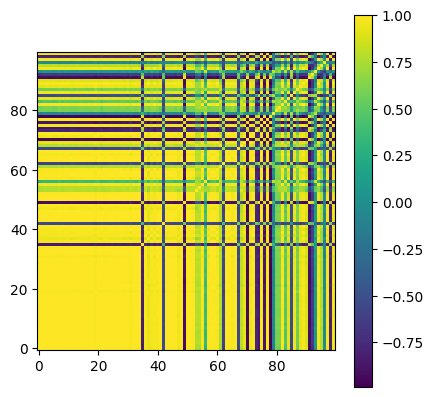

maxNumClusters: 50
clstrs length: 2
best clustr: 2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <= 1: [1] clstrs len: 2


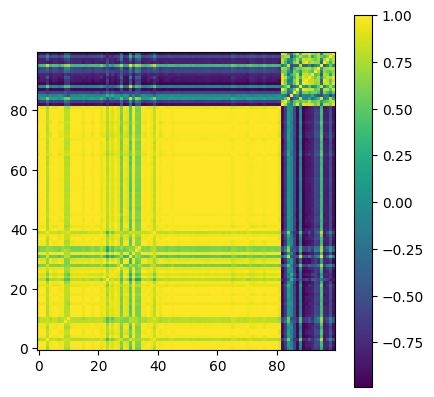

In [49]:
#Draw ground truth
matplotlib.pyplot.matshow(corr) #invert y-axis to get origo at lower left corner
matplotlib.pyplot.gca().xaxis.tick_bottom()
matplotlib.pyplot.gca().invert_yaxis()
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

#draw prediction based on ONC
corrNew, clstrsNew, silhNew = clusterKMeansTop(corr)
matplotlib.pyplot.matshow(corrNew)
matplotlib.pyplot.gca().xaxis.tick_bottom()
matplotlib.pyplot.gca().invert_yaxis()
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [50]:
cluster_lists = []

# Iterate through each cluster and its members
for cluster_number, cluster_indices in clstrsNew.items():
    cluster_list = []

    # Iterate through each index in the cluster
    for idx in cluster_indices:
        trial_number = top_trials[idx].number
        cluster_list.append(trial_number)

    cluster_lists.append(cluster_list)

# Print the lists for each cluster
for i, cluster_list in enumerate(cluster_lists):
    print(f"Cluster {i}: {cluster_list}")

Cluster 0: [89, 3, 18, 51, 17, 59, 58, 99, 91, 62, 44, 56, 28, 47, 6, 96, 104, 83, 40, 71, 48, 57, 26, 55, 13, 105, 95, 35, 101, 67, 63, 25, 52, 103, 1, 82, 30, 85, 21, 36, 80, 76, 53, 70, 42, 38, 66, 77, 37, 24, 31, 41, 34, 12, 73, 94, 19, 81, 4, 11, 16, 61, 43, 64, 9, 78, 49, 29, 102, 23, 2, 65, 74, 0, 79, 46, 8, 33, 75, 27, 93, 15]
Cluster 1: [88, 100, 92, 87, 98, 50, 60, 10, 7, 39, 5, 45, 20, 32, 54, 68, 22, 14]


In [51]:
top_10_features_per_cluster = []

for cluster_number, cluster_indices in clstrsNew.items():
    cluster_frequency = {}

    for idx in cluster_indices:
        trial_params = top_trials[idx].params
        for key, value in trial_params.items():
            if value == 1:
                cluster_frequency[key] = cluster_frequency.get(key, 0) + 1

    sorted_cluster_frequency = sorted(cluster_frequency.items(), key=lambda x: x[1], reverse=True)
    top_10_features_cluster = [feature for feature, _ in sorted_cluster_frequency[:10]]
    top_10_features_per_cluster.append(top_10_features_cluster)
    print(f"Top 10 features for Cluster {cluster_number}: {top_10_features_cluster}")

Top 10 features for Cluster 0: [14, 0, 6, 4, 11, 2, 9, 7, 12, 1]
Top 10 features for Cluster 1: [1, 6, 0, 9, 4, 8, 5, 10, 13, 2]


In [52]:
top_10_features_per_cluster

[[14, 0, 6, 4, 11, 2, 9, 7, 12, 1], [1, 6, 0, 9, 4, 8, 5, 10, 13, 2]]

In [53]:
top10_feat = pd.DataFrame(top_10_features_per_cluster)

In [54]:
selected_columns_cluster = []
for item in top_10_features_per_cluster:
  selected_columns = new_df_no_close_col.iloc[:, item]
  selected_columns_cluster.append(selected_columns)

In [55]:
selected_columns_cluster

[        others_dr  volume_adi  volatility_kcp  volatility_bbli  \
 1        0.021211 -755.000000        0.541667              0.0   
 2        0.042413 -674.333333        0.857143              0.0   
 3       -0.010599 -539.333333        0.744444              0.0   
 4       -0.031800 -539.333333        0.362745              0.0   
 5       -0.010603 -539.333333        0.245614              0.0   
 ...           ...         ...             ...              ...   
 356235   0.000000    0.000000        0.333333              0.0   
 356236   0.000000    0.000000        0.333333              0.0   
 356237   0.000000    0.000000        0.333333              0.0   
 356238   0.000000    0.000000        0.333333              0.0   
 356239   0.000000    0.000000        0.333333              0.0   
 
         trend_psar_down_indicator  volume_sma_em  trend_adx  trend_mass_index  \
 1                             0.0            0.0   0.000000          0.000000   
 2                            

# Model selection

## Custom Early Stopping

In [56]:
from xgboost import callback

In [57]:
min_delta = 0.0001
patience = 30


class CustomEarlyStopping(callback.TrainingCallback):
    def __init__(self, min_delta, patience, verbose=False):
        super().__init__()
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.best_score = np.inf
        self.wait = 0
        self.stopped_epoch = 0

    def after_iteration(self, model, epoch, evals_log):
        if not evals_log:
            return False
        metric_name = next(iter(evals_log['validation_0']))
        score = evals_log['validation_0'][metric_name][-1]
        if score < (self.best_score - self.min_delta):
            self.best_score = score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose:
                    print(f"\nStopping. Best score: {self.best_score}")
                self.stopped_epoch = epoch
                return True
        return False

    def get_best_score(self):
        return self.best_score

## Hyperparameter Tuning

In [58]:
def objective_params(trial, X_train, X_valid, y_train, y_valid, y_close):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
        }
    trade_threshold  = 0.0005

    # Check duplication and skip if it's detected.
    for t in trial.study.trials:
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue
        if t.params == trial.params:
            return np.nan #t.values  # Return the previous value without re-evaluating i


    custom_early_stopping_instance = CustomEarlyStopping(min_delta=min_delta, patience=patience, verbose=True)

    # Train the model
    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)


    pos, pnl, daily_pnl, sharpe_is = sharpe_for_vn30f(y_pred_train, y_close[:len(y_pred_train)], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    _, _, _, sharpe_oos = sharpe_for_vn30f(y_pred_valid, y_close[len(y_pred_train):], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    return sharpe_oos, abs((abs(sharpe_is / sharpe_oos))-1)

In [59]:
import pickle

In [60]:
best_params_list = []
for idx, data_item in enumerate(selected_columns_cluster):
    train_cols, _ = split_data(data_item)
    optuna_data = scale_data(train_cols)

    X_train, X_valid, y_train, y_valid = train_test_split(optuna_data,
                                                            train_data['Return'],
                                                            test_size=0.5,
                                                            shuffle=False)
    study = optuna.create_study(directions=['maximize', 'minimize'])

    unique_trials = 100
    while unique_trials > len(set(str(t.params) for t in study.trials)):
        study.optimize(lambda trial: objective_params(trial, X_train, X_valid, y_train, y_valid, train_data['Close']), n_trials=1)

    # Retrieve all trials
    trials = study.trials

    completed_trials = [t for t in study.trials if t.values is not None]

    # Sort trials based on objective values
    completed_trials.sort(key=lambda trial: trial.values, reverse=True)

    # Select top 1 trials
    params = completed_trials[0].params
    best_params_list.append(params)

    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)

#     model.save_model(f'best_in_cluster_{idx}.json')
    with open(f'best_in_cluster_{idx}.pkl', 'wb') as f:
        pickle.dump(model, f)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
[I 2024-07-02 08:17:11,047] A new study created in memory with name: no-name-6241c0a0-2bbe-4cf3-87c6-39f54a9db854


A new study created in memory with name: no-name-6241c0a0-2bbe-4cf3-87c6-39f54a9db854


[I 2024-07-02 08:22:09,852] Trial 0 finished with values: [2.0531716947696728, 0.5867621377315133] and parameters: {'n_estimators': 290, 'learning_rate': 0.056107759224974296, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9}. 


Trial 0 finished with values: [2.0531716947696728, 0.5867621377315133] and parameters: {'n_estimators': 290, 'learning_rate': 0.056107759224974296, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9}. 


[I 2024-07-02 08:23:27,503] Trial 1 finished with values: [2.6457352216902996, 0.05001867081850786] and parameters: {'n_estimators': 200, 'learning_rate': 0.04752119943135554, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3}. 


Trial 1 finished with values: [2.6457352216902996, 0.05001867081850786] and parameters: {'n_estimators': 200, 'learning_rate': 0.04752119943135554, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3}. 


[I 2024-07-02 08:26:47,924] Trial 2 finished with values: [2.6353179847059818, 0.19619314440449798] and parameters: {'n_estimators': 173, 'learning_rate': 0.055395465102020355, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


Trial 2 finished with values: [2.6353179847059818, 0.19619314440449798] and parameters: {'n_estimators': 173, 'learning_rate': 0.055395465102020355, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


[I 2024-07-02 08:30:31,037] Trial 3 finished with values: [1.4805054737662748, 2.2478106482627394] and parameters: {'n_estimators': 172, 'learning_rate': 0.06636579023265012, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


Trial 3 finished with values: [1.4805054737662748, 2.2478106482627394] and parameters: {'n_estimators': 172, 'learning_rate': 0.06636579023265012, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


[I 2024-07-02 08:31:42,838] Trial 4 finished with values: [3.875316499550838, 0.5976217718940242] and parameters: {'n_estimators': 111, 'learning_rate': 0.025821468153423878, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6}. 


Trial 4 finished with values: [3.875316499550838, 0.5976217718940242] and parameters: {'n_estimators': 111, 'learning_rate': 0.025821468153423878, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6}. 


[I 2024-07-02 08:36:09,703] Trial 5 finished with values: [1.630653633627541, 1.4561880000971104] and parameters: {'n_estimators': 206, 'learning_rate': 0.049522434362051546, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


Trial 5 finished with values: [1.630653633627541, 1.4561880000971104] and parameters: {'n_estimators': 206, 'learning_rate': 0.049522434362051546, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


[I 2024-07-02 08:41:56,342] Trial 6 finished with values: [2.194989051769747, 0.7175647285919897] and parameters: {'n_estimators': 268, 'learning_rate': 0.018074195927909292, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8}. 


Trial 6 finished with values: [2.194989051769747, 0.7175647285919897] and parameters: {'n_estimators': 268, 'learning_rate': 0.018074195927909292, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8}. 


[I 2024-07-02 08:46:26,198] Trial 7 finished with values: [2.251695731768208, 0.41833478036920635] and parameters: {'n_estimators': 299, 'learning_rate': 0.039965777821564095, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6}. 


Trial 7 finished with values: [2.251695731768208, 0.41833478036920635] and parameters: {'n_estimators': 299, 'learning_rate': 0.039965777821564095, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6}. 


[I 2024-07-02 08:50:29,610] Trial 8 finished with values: [1.1970578333456776, 2.6360567636240395] and parameters: {'n_estimators': 187, 'learning_rate': 0.04192523690843418, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


Trial 8 finished with values: [1.1970578333456776, 2.6360567636240395] and parameters: {'n_estimators': 187, 'learning_rate': 0.04192523690843418, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


[I 2024-07-02 08:51:08,515] Trial 9 finished with values: [3.341970027149656, 0.5591209423114305] and parameters: {'n_estimators': 60, 'learning_rate': 0.012615667180423284, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 9}. 


Trial 9 finished with values: [3.341970027149656, 0.5591209423114305] and parameters: {'n_estimators': 60, 'learning_rate': 0.012615667180423284, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 9}. 


[I 2024-07-02 08:52:48,606] Trial 10 finished with values: [2.9078382701670575, 0.07051108110902438] and parameters: {'n_estimators': 110, 'learning_rate': 0.06188324410622361, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 6}. 


Trial 10 finished with values: [2.9078382701670575, 0.07051108110902438] and parameters: {'n_estimators': 110, 'learning_rate': 0.06188324410622361, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 6}. 


[I 2024-07-02 08:54:32,425] Trial 11 finished with values: [2.886208881067029, 0.38774485706350637] and parameters: {'n_estimators': 160, 'learning_rate': 0.036202689401041696, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 7}. 


Trial 11 finished with values: [2.886208881067029, 0.38774485706350637] and parameters: {'n_estimators': 160, 'learning_rate': 0.036202689401041696, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 7}. 


[I 2024-07-02 08:58:45,070] Trial 12 finished with values: [2.0829441439955283, 1.4001227709839101] and parameters: {'n_estimators': 245, 'learning_rate': 0.09128385647856, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3}. 


Trial 12 finished with values: [2.0829441439955283, 1.4001227709839101] and parameters: {'n_estimators': 245, 'learning_rate': 0.09128385647856, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3}. 


[I 2024-07-02 09:01:15,636] Trial 13 finished with values: [0.8875823554344948, 4.3517909678920965] and parameters: {'n_estimators': 292, 'learning_rate': 0.09163016772669035, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. 


Trial 13 finished with values: [0.8875823554344948, 4.3517909678920965] and parameters: {'n_estimators': 292, 'learning_rate': 0.09163016772669035, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. 


[I 2024-07-02 09:04:47,652] Trial 14 finished with values: [0.05899750682233212, 84.60775814221725] and parameters: {'n_estimators': 165, 'learning_rate': 0.06125524715394435, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2}. 


Trial 14 finished with values: [0.05899750682233212, 84.60775814221725] and parameters: {'n_estimators': 165, 'learning_rate': 0.06125524715394435, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2}. 


[I 2024-07-02 09:06:55,289] Trial 15 finished with values: [3.3708654445725914, 0.2597841815395122] and parameters: {'n_estimators': 162, 'learning_rate': 0.032641214956143805, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. 


Trial 15 finished with values: [3.3708654445725914, 0.2597841815395122] and parameters: {'n_estimators': 162, 'learning_rate': 0.032641214956143805, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. 


[I 2024-07-02 09:11:52,352] Trial 16 finished with values: [-0.3895518527660075, 11.659247321828737] and parameters: {'n_estimators': 254, 'learning_rate': 0.03706454114409738, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 2}. 


Trial 16 finished with values: [-0.3895518527660075, 11.659247321828737] and parameters: {'n_estimators': 254, 'learning_rate': 0.03706454114409738, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 2}. 


[I 2024-07-02 09:14:50,341] Trial 17 finished with values: [2.7536944885438834, 0.133915928442345] and parameters: {'n_estimators': 170, 'learning_rate': 0.02731640923382212, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


Trial 17 finished with values: [2.7536944885438834, 0.133915928442345] and parameters: {'n_estimators': 170, 'learning_rate': 0.02731640923382212, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


[I 2024-07-02 09:18:57,007] Trial 18 finished with values: [2.2674373340286706, 0.7515570428072254] and parameters: {'n_estimators': 188, 'learning_rate': 0.09480013750592006, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 7}. 


Trial 18 finished with values: [2.2674373340286706, 0.7515570428072254] and parameters: {'n_estimators': 188, 'learning_rate': 0.09480013750592006, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 7}. 


[I 2024-07-02 09:20:02,689] Trial 19 finished with values: [3.2953323334354723, 0.13672741212008876] and parameters: {'n_estimators': 125, 'learning_rate': 0.09257255681800018, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


Trial 19 finished with values: [3.2953323334354723, 0.13672741212008876] and parameters: {'n_estimators': 125, 'learning_rate': 0.09257255681800018, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


[I 2024-07-02 09:23:07,585] Trial 20 finished with values: [1.7718850537616588, 1.007943516606951] and parameters: {'n_estimators': 177, 'learning_rate': 0.05030168235600407, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 4}. 


Trial 20 finished with values: [1.7718850537616588, 1.007943516606951] and parameters: {'n_estimators': 177, 'learning_rate': 0.05030168235600407, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 4}. 


[I 2024-07-02 09:25:09,755] Trial 21 finished with values: [2.552896604845565, 0.22462799528995547] and parameters: {'n_estimators': 133, 'learning_rate': 0.010608377513857471, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3}. 


Trial 21 finished with values: [2.552896604845565, 0.22462799528995547] and parameters: {'n_estimators': 133, 'learning_rate': 0.010608377513857471, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3}. 


[I 2024-07-02 09:28:26,314] Trial 22 finished with values: [3.055836933701858, 0.2661600731175052] and parameters: {'n_estimators': 251, 'learning_rate': 0.012880093313952058, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


Trial 22 finished with values: [3.055836933701858, 0.2661600731175052] and parameters: {'n_estimators': 251, 'learning_rate': 0.012880093313952058, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


[I 2024-07-02 09:30:21,959] Trial 23 finished with values: [3.881929390934153, 0.5983072257623222] and parameters: {'n_estimators': 177, 'learning_rate': 0.018610509253024623, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6}. 


Trial 23 finished with values: [3.881929390934153, 0.5983072257623222] and parameters: {'n_estimators': 177, 'learning_rate': 0.018610509253024623, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6}. 


[I 2024-07-02 09:34:46,871] Trial 24 finished with values: [2.426621273335057, 0.7779894959180664] and parameters: {'n_estimators': 254, 'learning_rate': 0.0771192858585189, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. 


Trial 24 finished with values: [2.426621273335057, 0.7779894959180664] and parameters: {'n_estimators': 254, 'learning_rate': 0.0771192858585189, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. 


[I 2024-07-02 09:35:13,408] Trial 25 finished with values: [3.4166223925076555, 0.5732147260566474] and parameters: {'n_estimators': 67, 'learning_rate': 0.03882544707377621, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 9}. 


Trial 25 finished with values: [3.4166223925076555, 0.5732147260566474] and parameters: {'n_estimators': 67, 'learning_rate': 0.03882544707377621, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 9}. 


[I 2024-07-02 09:36:09,106] Trial 26 finished with values: [2.3232556395568897, 0.06665919243434948] and parameters: {'n_estimators': 71, 'learning_rate': 0.0659662107036751, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 10}. 


Trial 26 finished with values: [2.3232556395568897, 0.06665919243434948] and parameters: {'n_estimators': 71, 'learning_rate': 0.0659662107036751, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 10}. 


[I 2024-07-02 09:38:18,125] Trial 27 finished with values: [2.128354380946831, 0.891698358354412] and parameters: {'n_estimators': 109, 'learning_rate': 0.05359865324127422, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


Trial 27 finished with values: [2.128354380946831, 0.891698358354412] and parameters: {'n_estimators': 109, 'learning_rate': 0.05359865324127422, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


[I 2024-07-02 09:40:56,946] Trial 28 finished with values: [2.757247761616817, 0.14959266258490633] and parameters: {'n_estimators': 203, 'learning_rate': 0.04319812751919723, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


Trial 28 finished with values: [2.757247761616817, 0.14959266258490633] and parameters: {'n_estimators': 203, 'learning_rate': 0.04319812751919723, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


[I 2024-07-02 09:41:44,767] Trial 29 finished with values: [3.454514241124337, 0.5590258298095062] and parameters: {'n_estimators': 90, 'learning_rate': 0.034797342627002965, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. 


Trial 29 finished with values: [3.454514241124337, 0.5590258298095062] and parameters: {'n_estimators': 90, 'learning_rate': 0.034797342627002965, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. 


[I 2024-07-02 09:43:40,963] Trial 30 finished with values: [3.0527174074400802, 0.0425271360930114] and parameters: {'n_estimators': 127, 'learning_rate': 0.06827831757654225, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


Trial 30 finished with values: [3.0527174074400802, 0.0425271360930114] and parameters: {'n_estimators': 127, 'learning_rate': 0.06827831757654225, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


[I 2024-07-02 09:46:38,470] Trial 31 finished with values: [2.4679380471330536, 0.5722777460678514] and parameters: {'n_estimators': 136, 'learning_rate': 0.043405347861781816, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 6}. 


Trial 31 finished with values: [2.4679380471330536, 0.5722777460678514] and parameters: {'n_estimators': 136, 'learning_rate': 0.043405347861781816, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 6}. 


[I 2024-07-02 09:51:49,161] Trial 32 finished with values: [1.6678545377460046, 1.2890258087543205] and parameters: {'n_estimators': 241, 'learning_rate': 0.08881662154265671, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 7}. 


Trial 32 finished with values: [1.6678545377460046, 1.2890258087543205] and parameters: {'n_estimators': 241, 'learning_rate': 0.08881662154265671, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 7}. 


[I 2024-07-02 09:53:11,178] Trial 33 finished with values: [2.1502407771734764, 0.1051391935206697] and parameters: {'n_estimators': 126, 'learning_rate': 0.08331697991930812, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 10}. 


Trial 33 finished with values: [2.1502407771734764, 0.1051391935206697] and parameters: {'n_estimators': 126, 'learning_rate': 0.08331697991930812, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 10}. 


[I 2024-07-02 09:57:39,693] Trial 34 finished with values: [2.3179516112169622, 0.7114832465836989] and parameters: {'n_estimators': 260, 'learning_rate': 0.07368456074641667, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 6}. 


Trial 34 finished with values: [2.3179516112169622, 0.7114832465836989] and parameters: {'n_estimators': 260, 'learning_rate': 0.07368456074641667, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 6}. 


[I 2024-07-02 09:59:29,403] Trial 35 finished with values: [2.296925407512307, 0.3370570676901401] and parameters: {'n_estimators': 106, 'learning_rate': 0.01976136033396897, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10}. 


Trial 35 finished with values: [2.296925407512307, 0.3370570676901401] and parameters: {'n_estimators': 106, 'learning_rate': 0.01976136033396897, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10}. 


[I 2024-07-02 10:04:17,511] Trial 36 finished with values: [2.7027933619484283, 0.440722495158981] and parameters: {'n_estimators': 246, 'learning_rate': 0.024817027122823885, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


Trial 36 finished with values: [2.7027933619484283, 0.440722495158981] and parameters: {'n_estimators': 246, 'learning_rate': 0.024817027122823885, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


[I 2024-07-02 10:07:23,371] Trial 37 finished with values: [2.000781720464356, 0.9011154707370632] and parameters: {'n_estimators': 158, 'learning_rate': 0.0897010317075779, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 8}. 


Trial 37 finished with values: [2.000781720464356, 0.9011154707370632] and parameters: {'n_estimators': 158, 'learning_rate': 0.0897010317075779, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 8}. 


[I 2024-07-02 10:07:50,322] Trial 38 finished with values: [2.8009449139987077, 0.48760407731408084] and parameters: {'n_estimators': 68, 'learning_rate': 0.03457633662413992, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 10}. 


Trial 38 finished with values: [2.8009449139987077, 0.48760407731408084] and parameters: {'n_estimators': 68, 'learning_rate': 0.03457633662413992, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 10}. 


[I 2024-07-02 10:10:10,328] Trial 39 finished with values: [2.542905430248778, 0.6427987226861684] and parameters: {'n_estimators': 178, 'learning_rate': 0.08643429680917326, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


Trial 39 finished with values: [2.542905430248778, 0.6427987226861684] and parameters: {'n_estimators': 178, 'learning_rate': 0.08643429680917326, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


[I 2024-07-02 10:11:49,031] Trial 40 finished with values: [1.2034212403979871, 2.0812713351140553] and parameters: {'n_estimators': 250, 'learning_rate': 0.06088460311382207, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 1}. 


Trial 40 finished with values: [1.2034212403979871, 2.0812713351140553] and parameters: {'n_estimators': 250, 'learning_rate': 0.06088460311382207, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 1}. 


[I 2024-07-02 10:15:50,242] Trial 41 finished with values: [0.733113633566872, 7.915616904010713] and parameters: {'n_estimators': 270, 'learning_rate': 0.0938399661592644, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1}. 


Trial 41 finished with values: [0.733113633566872, 7.915616904010713] and parameters: {'n_estimators': 270, 'learning_rate': 0.0938399661592644, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1}. 


[I 2024-07-02 10:19:19,391] Trial 42 finished with values: [2.034218902193511, 0.723821737554772] and parameters: {'n_estimators': 177, 'learning_rate': 0.06053606843334872, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 9}. 


Trial 42 finished with values: [2.034218902193511, 0.723821737554772] and parameters: {'n_estimators': 177, 'learning_rate': 0.06053606843334872, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 9}. 


[I 2024-07-02 10:22:12,205] Trial 43 finished with values: [2.734692638985538, 0.09328563370469922] and parameters: {'n_estimators': 183, 'learning_rate': 0.05556481728861625, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 9}. 


Trial 43 finished with values: [2.734692638985538, 0.09328563370469922] and parameters: {'n_estimators': 183, 'learning_rate': 0.05556481728861625, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 9}. 


[I 2024-07-02 10:24:35,890] Trial 44 finished with values: [1.886761672120877, 1.251932286105256] and parameters: {'n_estimators': 265, 'learning_rate': 0.09649864455287553, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 4}. 


Trial 44 finished with values: [1.886761672120877, 1.251932286105256] and parameters: {'n_estimators': 265, 'learning_rate': 0.09649864455287553, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 4}. 


[I 2024-07-02 10:26:38,347] Trial 45 finished with values: [2.426518581284482, 0.2640735197041766] and parameters: {'n_estimators': 113, 'learning_rate': 0.07574169579119203, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


Trial 45 finished with values: [2.426518581284482, 0.2640735197041766] and parameters: {'n_estimators': 113, 'learning_rate': 0.07574169579119203, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


[I 2024-07-02 10:28:08,534] Trial 46 finished with values: [2.5999353174736473, 0.18431216505307568] and parameters: {'n_estimators': 220, 'learning_rate': 0.08940724232003681, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


Trial 46 finished with values: [2.5999353174736473, 0.18431216505307568] and parameters: {'n_estimators': 220, 'learning_rate': 0.08940724232003681, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


[I 2024-07-02 10:33:25,437] Trial 47 finished with values: [2.1662617469415313, 0.6882825142952245] and parameters: {'n_estimators': 261, 'learning_rate': 0.0881143092948325, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 9}. 


Trial 47 finished with values: [2.1662617469415313, 0.6882825142952245] and parameters: {'n_estimators': 261, 'learning_rate': 0.0881143092948325, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 9}. 


[I 2024-07-02 10:35:08,939] Trial 48 finished with values: [3.231567060617201, 0.4573611223839019] and parameters: {'n_estimators': 254, 'learning_rate': 0.054533442848998075, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8}. 


Trial 48 finished with values: [3.231567060617201, 0.4573611223839019] and parameters: {'n_estimators': 254, 'learning_rate': 0.054533442848998075, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8}. 


[I 2024-07-02 10:38:00,234] Trial 49 finished with values: [3.278327525869705, 0.4530674178478482] and parameters: {'n_estimators': 253, 'learning_rate': 0.02115684369239695, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8}. 


Trial 49 finished with values: [3.278327525869705, 0.4530674178478482] and parameters: {'n_estimators': 253, 'learning_rate': 0.02115684369239695, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8}. 


[I 2024-07-02 10:41:26,397] Trial 50 finished with values: [1.9251486959528858, 0.9124286525836616] and parameters: {'n_estimators': 190, 'learning_rate': 0.08881662154265671, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 7}. 


Trial 50 finished with values: [1.9251486959528858, 0.9124286525836616] and parameters: {'n_estimators': 190, 'learning_rate': 0.08881662154265671, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 7}. 


[I 2024-07-02 10:44:19,945] Trial 51 finished with values: [2.044037510100263, 0.44157189592708534] and parameters: {'n_estimators': 160, 'learning_rate': 0.08562124141175491, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 10}. 


Trial 51 finished with values: [2.044037510100263, 0.44157189592708534] and parameters: {'n_estimators': 160, 'learning_rate': 0.08562124141175491, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 10}. 


[I 2024-07-02 10:50:17,263] Trial 52 finished with values: [1.3334853994664684, 2.1835447094514957] and parameters: {'n_estimators': 265, 'learning_rate': 0.07601663648687874, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7}. 


Trial 52 finished with values: [1.3334853994664684, 2.1835447094514957] and parameters: {'n_estimators': 265, 'learning_rate': 0.07601663648687874, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7}. 


[I 2024-07-02 10:50:54,285] Trial 53 finished with values: [2.9849592044411697, 0.5700200160165614] and parameters: {'n_estimators': 68, 'learning_rate': 0.03457633662413992, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


Trial 53 finished with values: [2.9849592044411697, 0.5700200160165614] and parameters: {'n_estimators': 68, 'learning_rate': 0.03457633662413992, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


[I 2024-07-02 10:52:44,703] Trial 54 finished with values: [2.9331056586883846, 0.1888294349316908] and parameters: {'n_estimators': 203, 'learning_rate': 0.03842381082632097, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


Trial 54 finished with values: [2.9331056586883846, 0.1888294349316908] and parameters: {'n_estimators': 203, 'learning_rate': 0.03842381082632097, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


[I 2024-07-02 10:55:43,643] Trial 55 finished with values: [2.819002561434361, 0.0030063339570240988] and parameters: {'n_estimators': 220, 'learning_rate': 0.08940724232003681, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


Trial 55 finished with values: [2.819002561434361, 0.0030063339570240988] and parameters: {'n_estimators': 220, 'learning_rate': 0.08940724232003681, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


[I 2024-07-02 10:57:10,591] Trial 56 finished with values: [2.350121258330147, 0.32039455769110914] and parameters: {'n_estimators': 71, 'learning_rate': 0.0659662107036751, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 7}. 


Trial 56 finished with values: [2.350121258330147, 0.32039455769110914] and parameters: {'n_estimators': 71, 'learning_rate': 0.0659662107036751, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 7}. 


[I 2024-07-02 10:58:26,659] Trial 57 finished with values: [3.3377423432781805, 0.5060191982842259] and parameters: {'n_estimators': 186, 'learning_rate': 0.054533442848998075, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8}. 


Trial 57 finished with values: [3.3377423432781805, 0.5060191982842259] and parameters: {'n_estimators': 186, 'learning_rate': 0.054533442848998075, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8}. 


[I 2024-07-02 11:01:59,837] Trial 58 finished with values: [1.9412904759680887, 1.0737056815791592] and parameters: {'n_estimators': 197, 'learning_rate': 0.0771192858585189, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 4}. 


Trial 58 finished with values: [1.9412904759680887, 1.0737056815791592] and parameters: {'n_estimators': 197, 'learning_rate': 0.0771192858585189, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 4}. 


[I 2024-07-02 11:03:49,160] Trial 59 finished with values: [1.8381667340074288, 1.1217417810366066] and parameters: {'n_estimators': 90, 'learning_rate': 0.034797342627002965, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 4}. 


Trial 59 finished with values: [1.8381667340074288, 1.1217417810366066] and parameters: {'n_estimators': 90, 'learning_rate': 0.034797342627002965, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 4}. 


[I 2024-07-02 11:06:20,371] Trial 60 finished with values: [2.407507064809303, 0.5612592294026224] and parameters: {'n_estimators': 112, 'learning_rate': 0.043405347861781816, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 6}. 


Trial 60 finished with values: [2.407507064809303, 0.5612592294026224] and parameters: {'n_estimators': 112, 'learning_rate': 0.043405347861781816, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 6}. 


[I 2024-07-02 11:11:21,038] Trial 61 finished with values: [2.7841413357352276, 0.3273511131484883] and parameters: {'n_estimators': 246, 'learning_rate': 0.015736024410445693, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5}. 


Trial 61 finished with values: [2.7841413357352276, 0.3273511131484883] and parameters: {'n_estimators': 246, 'learning_rate': 0.015736024410445693, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5}. 


[I 2024-07-02 11:15:00,008] Trial 62 finished with values: [1.8238051004877542, 0.8123412783880861] and parameters: {'n_estimators': 268, 'learning_rate': 0.0659662107036751, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6}. 


Trial 62 finished with values: [1.8238051004877542, 0.8123412783880861] and parameters: {'n_estimators': 268, 'learning_rate': 0.0659662107036751, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6}. 


[I 2024-07-02 11:16:02,238] Trial 63 finished with values: [2.9852416089749774, 0.5307277242643392] and parameters: {'n_estimators': 113, 'learning_rate': 0.05752973254602077, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


Trial 63 finished with values: [2.9852416089749774, 0.5307277242643392] and parameters: {'n_estimators': 113, 'learning_rate': 0.05752973254602077, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


[I 2024-07-02 11:18:19,925] Trial 64 finished with values: [1.6795179829083098, 0.9636051057907298] and parameters: {'n_estimators': 127, 'learning_rate': 0.06827831757654225, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


Trial 64 finished with values: [1.6795179829083098, 0.9636051057907298] and parameters: {'n_estimators': 127, 'learning_rate': 0.06827831757654225, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


[I 2024-07-02 11:19:57,374] Trial 65 finished with values: [3.4433681200036275, 0.05491564431429763] and parameters: {'n_estimators': 90, 'learning_rate': 0.039303844540264886, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. 


Trial 65 finished with values: [3.4433681200036275, 0.05491564431429763] and parameters: {'n_estimators': 90, 'learning_rate': 0.039303844540264886, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. 


[I 2024-07-02 11:21:34,030] Trial 66 finished with values: [3.284656239946589, 0.21405934951347005] and parameters: {'n_estimators': 177, 'learning_rate': 0.0449273421770978, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


Trial 66 finished with values: [3.284656239946589, 0.21405934951347005] and parameters: {'n_estimators': 177, 'learning_rate': 0.0449273421770978, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


[I 2024-07-02 11:24:26,391] Trial 67 finished with values: [3.1056489511039693, 0.5136838960835334] and parameters: {'n_estimators': 253, 'learning_rate': 0.012615667180423284, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 9}. 


Trial 67 finished with values: [3.1056489511039693, 0.5136838960835334] and parameters: {'n_estimators': 253, 'learning_rate': 0.012615667180423284, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 9}. 


[W 2024-07-02 11:24:26,429] Trial 68 failed with parameters: {'n_estimators': 106, 'learning_rate': 0.01976136033396897, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10} because of the following error: The value nan is not acceptable.


Trial 68 failed with parameters: {'n_estimators': 106, 'learning_rate': 0.01976136033396897, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10} because of the following error: The value nan is not acceptable.


[W 2024-07-02 11:24:26,432] Trial 68 failed with value nan.


Trial 68 failed with value nan.


[I 2024-07-02 11:27:14,563] Trial 69 finished with values: [3.0249007598947526, 0.02165339503502728] and parameters: {'n_estimators': 177, 'learning_rate': 0.06188324410622361, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 9}. 


Trial 69 finished with values: [3.0249007598947526, 0.02165339503502728] and parameters: {'n_estimators': 177, 'learning_rate': 0.06188324410622361, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 9}. 


[I 2024-07-02 11:32:16,807] Trial 70 finished with values: [2.3960998688128528, 0.4290815614018588] and parameters: {'n_estimators': 246, 'learning_rate': 0.024817027122823885, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


Trial 70 finished with values: [2.3960998688128528, 0.4290815614018588] and parameters: {'n_estimators': 246, 'learning_rate': 0.024817027122823885, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


[I 2024-07-02 11:33:38,971] Trial 71 finished with values: [3.327419713064908, 0.5083660018322609] and parameters: {'n_estimators': 200, 'learning_rate': 0.05868453233928045, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 8}. 


Trial 71 finished with values: [3.327419713064908, 0.5083660018322609] and parameters: {'n_estimators': 200, 'learning_rate': 0.05868453233928045, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 8}. 


[I 2024-07-02 11:35:11,212] Trial 72 finished with values: [2.161117621478921, 0.17713872034914835] and parameters: {'n_estimators': 113, 'learning_rate': 0.06391577228051672, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 9}. 


Trial 72 finished with values: [2.161117621478921, 0.17713872034914835] and parameters: {'n_estimators': 113, 'learning_rate': 0.06391577228051672, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 9}. 


[I 2024-07-02 11:38:00,421] Trial 73 finished with values: [2.5400368763691072, 0.2075101723496635] and parameters: {'n_estimators': 156, 'learning_rate': 0.043405347861781816, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10}. 


Trial 73 finished with values: [2.5400368763691072, 0.2075101723496635] and parameters: {'n_estimators': 156, 'learning_rate': 0.043405347861781816, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10}. 


[I 2024-07-02 11:40:52,543] Trial 74 finished with values: [2.3068440562854313, 0.04403194004829514] and parameters: {'n_estimators': 253, 'learning_rate': 0.05484589416622992, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 10}. 


Trial 74 finished with values: [2.3068440562854313, 0.04403194004829514] and parameters: {'n_estimators': 253, 'learning_rate': 0.05484589416622992, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 10}. 


[W 2024-07-02 11:40:52,580] Trial 75 failed with parameters: {'n_estimators': 60, 'learning_rate': 0.012615667180423284, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 9} because of the following error: The value nan is not acceptable.


Trial 75 failed with parameters: {'n_estimators': 60, 'learning_rate': 0.012615667180423284, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 9} because of the following error: The value nan is not acceptable.


[W 2024-07-02 11:40:52,584] Trial 75 failed with value nan.


Trial 75 failed with value nan.


[W 2024-07-02 11:40:52,623] Trial 76 failed with parameters: {'n_estimators': 110, 'learning_rate': 0.06188324410622361, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 6} because of the following error: The value nan is not acceptable.


Trial 76 failed with parameters: {'n_estimators': 110, 'learning_rate': 0.06188324410622361, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 6} because of the following error: The value nan is not acceptable.


[W 2024-07-02 11:40:52,625] Trial 76 failed with value nan.


Trial 76 failed with value nan.


[I 2024-07-02 11:43:47,991] Trial 77 finished with values: [2.459852361889969, 0.3865393863281408] and parameters: {'n_estimators': 160, 'learning_rate': 0.036202689401041696, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9}. 


Trial 77 finished with values: [2.459852361889969, 0.3865393863281408] and parameters: {'n_estimators': 160, 'learning_rate': 0.036202689401041696, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9}. 


[I 2024-07-02 11:46:01,399] Trial 78 finished with values: [2.542033046929799, 0.13094892664136126] and parameters: {'n_estimators': 122, 'learning_rate': 0.055395465102020355, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 10}. 


Trial 78 finished with values: [2.542033046929799, 0.13094892664136126] and parameters: {'n_estimators': 122, 'learning_rate': 0.055395465102020355, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 10}. 


[W 2024-07-02 11:46:01,441] Trial 79 failed with parameters: {'n_estimators': 106, 'learning_rate': 0.01976136033396897, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10} because of the following error: The value nan is not acceptable.


Trial 79 failed with parameters: {'n_estimators': 106, 'learning_rate': 0.01976136033396897, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10} because of the following error: The value nan is not acceptable.


[W 2024-07-02 11:46:01,443] Trial 79 failed with value nan.


Trial 79 failed with value nan.


[I 2024-07-02 11:49:38,712] Trial 80 finished with values: [1.894071337090869, 1.3779705238605393] and parameters: {'n_estimators': 200, 'learning_rate': 0.07574169579119203, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


Trial 80 finished with values: [1.894071337090869, 1.3779705238605393] and parameters: {'n_estimators': 200, 'learning_rate': 0.07574169579119203, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


[I 2024-07-02 11:53:54,982] Trial 81 finished with values: [2.524218226208715, 0.3144708675668346] and parameters: {'n_estimators': 237, 'learning_rate': 0.02807280586171291, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 6}. 


Trial 81 finished with values: [2.524218226208715, 0.3144708675668346] and parameters: {'n_estimators': 237, 'learning_rate': 0.02807280586171291, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 6}. 


[W 2024-07-02 11:53:55,025] Trial 82 failed with parameters: {'n_estimators': 177, 'learning_rate': 0.018610509253024623, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6} because of the following error: The value nan is not acceptable.


Trial 82 failed with parameters: {'n_estimators': 177, 'learning_rate': 0.018610509253024623, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6} because of the following error: The value nan is not acceptable.


[W 2024-07-02 11:53:55,029] Trial 82 failed with value nan.


Trial 82 failed with value nan.


[I 2024-07-02 11:56:06,700] Trial 83 finished with values: [3.4777575292229805, 0.21338132864208048] and parameters: {'n_estimators': 162, 'learning_rate': 0.03457633662413992, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5}. 


Trial 83 finished with values: [3.4777575292229805, 0.21338132864208048] and parameters: {'n_estimators': 162, 'learning_rate': 0.03457633662413992, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5}. 


[I 2024-07-02 11:58:36,185] Trial 84 finished with values: [2.535266913512135, 0.3112249420001536] and parameters: {'n_estimators': 111, 'learning_rate': 0.014228047112286573, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 7}. 


Trial 84 finished with values: [2.535266913512135, 0.3112249420001536] and parameters: {'n_estimators': 111, 'learning_rate': 0.014228047112286573, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 7}. 


[W 2024-07-02 11:58:36,232] Trial 85 failed with parameters: {'n_estimators': 71, 'learning_rate': 0.0659662107036751, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 10} because of the following error: The value nan is not acceptable.


Trial 85 failed with parameters: {'n_estimators': 71, 'learning_rate': 0.0659662107036751, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 10} because of the following error: The value nan is not acceptable.


[W 2024-07-02 11:58:36,234] Trial 85 failed with value nan.


Trial 85 failed with value nan.


[I 2024-07-02 12:02:01,423] Trial 86 finished with values: [1.9034488231024167, 0.5209341440410049] and parameters: {'n_estimators': 253, 'learning_rate': 0.08643429680917326, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 10}. 


Trial 86 finished with values: [1.9034488231024167, 0.5209341440410049] and parameters: {'n_estimators': 253, 'learning_rate': 0.08643429680917326, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 10}. 


[I 2024-07-02 12:06:43,107] Trial 87 finished with values: [2.4289585667442855, 0.5841059970600477] and parameters: {'n_estimators': 210, 'learning_rate': 0.043405347861781816, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6}. 


Trial 87 finished with values: [2.4289585667442855, 0.5841059970600477] and parameters: {'n_estimators': 210, 'learning_rate': 0.043405347861781816, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6}. 


[I 2024-07-02 12:08:46,487] Trial 88 finished with values: [2.3852479424817608, 0.1828267586311082] and parameters: {'n_estimators': 183, 'learning_rate': 0.05556481728861625, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 10}. 


Trial 88 finished with values: [2.3852479424817608, 0.1828267586311082] and parameters: {'n_estimators': 183, 'learning_rate': 0.05556481728861625, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 10}. 


[I 2024-07-02 12:10:49,001] Trial 89 finished with values: [2.8231377940254583, 0.05883823696468227] and parameters: {'n_estimators': 151, 'learning_rate': 0.0659662107036751, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4}. 


Trial 89 finished with values: [2.8231377940254583, 0.05883823696468227] and parameters: {'n_estimators': 151, 'learning_rate': 0.0659662107036751, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4}. 


[I 2024-07-02 12:12:54,217] Trial 90 finished with values: [3.073072979385423, 0.047893855952315545] and parameters: {'n_estimators': 133, 'learning_rate': 0.06827831757654225, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


Trial 90 finished with values: [3.073072979385423, 0.047893855952315545] and parameters: {'n_estimators': 133, 'learning_rate': 0.06827831757654225, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


[I 2024-07-02 12:14:36,355] Trial 91 finished with values: [1.920855748238815, 1.0091685684873046] and parameters: {'n_estimators': 95, 'learning_rate': 0.05006791714551251, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3}. 


Trial 91 finished with values: [1.920855748238815, 1.0091685684873046] and parameters: {'n_estimators': 95, 'learning_rate': 0.05006791714551251, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3}. 


[I 2024-07-02 12:15:44,131] Trial 92 finished with values: [3.0472359398825355, 0.005973487745317474] and parameters: {'n_estimators': 125, 'learning_rate': 0.09257255681800018, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 4}. 


Trial 92 finished with values: [3.0472359398825355, 0.005973487745317474] and parameters: {'n_estimators': 125, 'learning_rate': 0.09257255681800018, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 4}. 


[I 2024-07-02 12:16:33,001] Trial 93 finished with values: [3.500661044614448, 0.5661883205548444] and parameters: {'n_estimators': 90, 'learning_rate': 0.032641214956143805, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


Trial 93 finished with values: [3.500661044614448, 0.5661883205548444] and parameters: {'n_estimators': 90, 'learning_rate': 0.032641214956143805, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


[I 2024-07-02 12:17:55,767] Trial 94 finished with values: [3.0970830715257947, 0.014905862810489223] and parameters: {'n_estimators': 67, 'learning_rate': 0.02115684369239695, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 9}. 


Trial 94 finished with values: [3.0970830715257947, 0.014905862810489223] and parameters: {'n_estimators': 67, 'learning_rate': 0.02115684369239695, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 9}. 


[I 2024-07-02 12:22:21,471] Trial 95 finished with values: [1.9765187612113233, 1.1774767506871302] and parameters: {'n_estimators': 245, 'learning_rate': 0.04360807545845966, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3}. 


Trial 95 finished with values: [1.9765187612113233, 1.1774767506871302] and parameters: {'n_estimators': 245, 'learning_rate': 0.04360807545845966, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3}. 


[I 2024-07-02 12:26:56,416] Trial 96 finished with values: [1.875494046972475, 0.8599853956580552] and parameters: {'n_estimators': 254, 'learning_rate': 0.07368456074641667, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 8}. 


Trial 96 finished with values: [1.875494046972475, 0.8599853956580552] and parameters: {'n_estimators': 254, 'learning_rate': 0.07368456074641667, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 8}. 


[I 2024-07-02 12:28:41,464] Trial 97 finished with values: [3.099564749155962, 0.03517003812514208] and parameters: {'n_estimators': 110, 'learning_rate': 0.05359865324127422, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 6}. 


Trial 97 finished with values: [3.099564749155962, 0.03517003812514208] and parameters: {'n_estimators': 110, 'learning_rate': 0.05359865324127422, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 6}. 


[I 2024-07-02 12:30:48,257] Trial 98 finished with values: [1.5600509006409726, 1.4610183258857763] and parameters: {'n_estimators': 133, 'learning_rate': 0.08435618116224544, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3}. 


Trial 98 finished with values: [1.5600509006409726, 1.4610183258857763] and parameters: {'n_estimators': 133, 'learning_rate': 0.08435618116224544, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3}. 


[I 2024-07-02 12:35:16,615] Trial 99 finished with values: [0.7006751920889521, 8.321954955297457] and parameters: {'n_estimators': 286, 'learning_rate': 0.09257255681800018, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1}. 


Trial 99 finished with values: [0.7006751920889521, 8.321954955297457] and parameters: {'n_estimators': 286, 'learning_rate': 0.09257255681800018, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1}. 


[I 2024-07-02 12:38:20,157] Trial 100 finished with values: [2.3808712451197978, 0.3482640397380583] and parameters: {'n_estimators': 170, 'learning_rate': 0.0771192858585189, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


Trial 100 finished with values: [2.3808712451197978, 0.3482640397380583] and parameters: {'n_estimators': 170, 'learning_rate': 0.0771192858585189, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


[I 2024-07-02 12:39:49,911] Trial 101 finished with values: [3.357533654087623, 0.5742286923046216] and parameters: {'n_estimators': 220, 'learning_rate': 0.026545627362991216, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 9}. 


Trial 101 finished with values: [3.357533654087623, 0.5742286923046216] and parameters: {'n_estimators': 220, 'learning_rate': 0.026545627362991216, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 9}. 


[I 2024-07-02 12:42:18,474] Trial 102 finished with values: [3.4525685014483476, 0.5319807872947884] and parameters: {'n_estimators': 220, 'learning_rate': 0.016693899250040754, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


Trial 102 finished with values: [3.4525685014483476, 0.5319807872947884] and parameters: {'n_estimators': 220, 'learning_rate': 0.016693899250040754, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


[I 2024-07-02 12:45:36,146] Trial 103 finished with values: [2.3932409094078917, 0.6406767332295544] and parameters: {'n_estimators': 162, 'learning_rate': 0.032641214956143805, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 5}. 


Trial 103 finished with values: [2.3932409094078917, 0.6406767332295544] and parameters: {'n_estimators': 162, 'learning_rate': 0.032641214956143805, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 5}. 


[I 2024-07-02 12:48:26,095] Trial 104 finished with values: [2.1741211607440496, 0.6161529126813448] and parameters: {'n_estimators': 126, 'learning_rate': 0.0897010317075779, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 10}. 


Trial 104 finished with values: [2.1741211607440496, 0.6161529126813448] and parameters: {'n_estimators': 126, 'learning_rate': 0.0897010317075779, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 10}. 


[I 2024-07-02 12:54:26,147] Trial 105 finished with values: [2.06821358957338, 1.273481719480594] and parameters: {'n_estimators': 268, 'learning_rate': 0.09072048307888614, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5}. 


Trial 105 finished with values: [2.06821358957338, 1.273481719480594] and parameters: {'n_estimators': 268, 'learning_rate': 0.09072048307888614, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5}. 


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
[I 2024-07-02 12:56:25,549] A new study created in memory with name: no-name-f91fcd6c-79b6-444d-a0f0-8c0b17ae6b17


A new study created in memory with name: no-name-f91fcd6c-79b6-444d-a0f0-8c0b17ae6b17


[I 2024-07-02 12:58:57,595] Trial 0 finished with values: [0.17583392030778186, 3.936466073444537] and parameters: {'n_estimators': 291, 'learning_rate': 0.013840455108373334, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


Trial 0 finished with values: [0.17583392030778186, 3.936466073444537] and parameters: {'n_estimators': 291, 'learning_rate': 0.013840455108373334, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


[I 2024-07-02 13:00:42,490] Trial 1 finished with values: [-0.27486436504026723, 6.451759966298147] and parameters: {'n_estimators': 115, 'learning_rate': 0.058703850137011696, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 8}. 


Trial 1 finished with values: [-0.27486436504026723, 6.451759966298147] and parameters: {'n_estimators': 115, 'learning_rate': 0.058703850137011696, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 8}. 


[I 2024-07-02 13:03:44,554] Trial 2 finished with values: [0.8798254687984526, 3.6635455887454453] and parameters: {'n_estimators': 279, 'learning_rate': 0.0316751948283739, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 1}. 


Trial 2 finished with values: [0.8798254687984526, 3.6635455887454453] and parameters: {'n_estimators': 279, 'learning_rate': 0.0316751948283739, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 1}. 


[I 2024-07-02 13:05:25,570] Trial 3 finished with values: [-0.9860437263658898, 1.816988214928759] and parameters: {'n_estimators': 97, 'learning_rate': 0.03862538068465303, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 3}. 


Trial 3 finished with values: [-0.9860437263658898, 1.816988214928759] and parameters: {'n_estimators': 97, 'learning_rate': 0.03862538068465303, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 3}. 


[I 2024-07-02 13:08:35,322] Trial 4 finished with values: [-0.2736143462423785, 6.6146572995873365] and parameters: {'n_estimators': 182, 'learning_rate': 0.04837256569816015, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 9}. 


Trial 4 finished with values: [-0.2736143462423785, 6.6146572995873365] and parameters: {'n_estimators': 182, 'learning_rate': 0.04837256569816015, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 9}. 


[I 2024-07-02 13:10:51,793] Trial 5 finished with values: [-0.4551913985580098, 2.6464838503609314] and parameters: {'n_estimators': 260, 'learning_rate': 0.04962270112524092, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


Trial 5 finished with values: [-0.4551913985580098, 2.6464838503609314] and parameters: {'n_estimators': 260, 'learning_rate': 0.04962270112524092, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


[I 2024-07-02 13:12:10,919] Trial 6 finished with values: [0.2609972278004103, 2.558221343548303] and parameters: {'n_estimators': 201, 'learning_rate': 0.06503582464971935, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 6}. 


Trial 6 finished with values: [0.2609972278004103, 2.558221343548303] and parameters: {'n_estimators': 201, 'learning_rate': 0.06503582464971935, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 6}. 


[I 2024-07-02 13:14:31,408] Trial 7 finished with values: [0.2708987215624063, 9.65815288817191] and parameters: {'n_estimators': 135, 'learning_rate': 0.07349271981211901, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 5}. 


Trial 7 finished with values: [0.2708987215624063, 9.65815288817191] and parameters: {'n_estimators': 135, 'learning_rate': 0.07349271981211901, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 5}. 


[I 2024-07-02 13:20:42,150] Trial 8 finished with values: [0.5399681866739013, 6.834156141496109] and parameters: {'n_estimators': 284, 'learning_rate': 0.03272286803015645, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


Trial 8 finished with values: [0.5399681866739013, 6.834156141496109] and parameters: {'n_estimators': 284, 'learning_rate': 0.03272286803015645, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


[I 2024-07-02 13:24:22,152] Trial 9 finished with values: [-1.0641222591214186, 1.3436091802406072] and parameters: {'n_estimators': 211, 'learning_rate': 0.08162476018542492, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 10}. 


Trial 9 finished with values: [-1.0641222591214186, 1.3436091802406072] and parameters: {'n_estimators': 211, 'learning_rate': 0.08162476018542492, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 10}. 


[I 2024-07-02 13:25:02,560] Trial 10 finished with values: [0.21190801577141988, 5.509598289474645] and parameters: {'n_estimators': 77, 'learning_rate': 0.07159458018934321, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3}. 


Trial 10 finished with values: [0.21190801577141988, 5.509598289474645] and parameters: {'n_estimators': 77, 'learning_rate': 0.07159458018934321, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3}. 


[I 2024-07-02 13:28:13,834] Trial 11 finished with values: [0.8762646984328495, 2.6813486171108356] and parameters: {'n_estimators': 147, 'learning_rate': 0.03728220413521061, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


Trial 11 finished with values: [0.8762646984328495, 2.6813486171108356] and parameters: {'n_estimators': 147, 'learning_rate': 0.03728220413521061, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


[I 2024-07-02 13:31:45,659] Trial 12 finished with values: [-1.2660405743436487, 0.6303617997673749] and parameters: {'n_estimators': 277, 'learning_rate': 0.06118863292880984, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 8}. 


Trial 12 finished with values: [-1.2660405743436487, 0.6303617997673749] and parameters: {'n_estimators': 277, 'learning_rate': 0.06118863292880984, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 8}. 


[I 2024-07-02 13:32:58,293] Trial 13 finished with values: [-0.30655808103668336, 3.891532727268631] and parameters: {'n_estimators': 145, 'learning_rate': 0.08450440194718761, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


Trial 13 finished with values: [-0.30655808103668336, 3.891532727268631] and parameters: {'n_estimators': 145, 'learning_rate': 0.08450440194718761, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


[I 2024-07-02 13:37:04,005] Trial 14 finished with values: [0.4747751154622355, 3.6702019998687083] and parameters: {'n_estimators': 281, 'learning_rate': 0.011101630507322711, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 5}. 


Trial 14 finished with values: [0.4747751154622355, 3.6702019998687083] and parameters: {'n_estimators': 281, 'learning_rate': 0.011101630507322711, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 5}. 


[I 2024-07-02 13:38:33,655] Trial 15 finished with values: [0.7017952106681612, 4.259092809576361] and parameters: {'n_estimators': 72, 'learning_rate': 0.06486859724985619, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2}. 


Trial 15 finished with values: [0.7017952106681612, 4.259092809576361] and parameters: {'n_estimators': 72, 'learning_rate': 0.06486859724985619, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2}. 


[I 2024-07-02 13:41:21,437] Trial 16 finished with values: [1.1326172096805418, 3.7547848188943442] and parameters: {'n_estimators': 194, 'learning_rate': 0.05906982967806196, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}. 


Trial 16 finished with values: [1.1326172096805418, 3.7547848188943442] and parameters: {'n_estimators': 194, 'learning_rate': 0.05906982967806196, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}. 


[I 2024-07-02 13:41:51,937] Trial 17 finished with values: [0.4333465989290173, 1.1937307874945748] and parameters: {'n_estimators': 60, 'learning_rate': 0.09874025472739986, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 8}. 


Trial 17 finished with values: [0.4333465989290173, 1.1937307874945748] and parameters: {'n_estimators': 60, 'learning_rate': 0.09874025472739986, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 8}. 


[I 2024-07-02 13:43:55,594] Trial 18 finished with values: [-1.280604946317588, 0.623780698597975] and parameters: {'n_estimators': 141, 'learning_rate': 0.0622745675562705, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 7}. 


Trial 18 finished with values: [-1.280604946317588, 0.623780698597975] and parameters: {'n_estimators': 141, 'learning_rate': 0.0622745675562705, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 7}. 


[I 2024-07-02 13:46:38,029] Trial 19 finished with values: [0.40147745281595554, 3.9849551367427845] and parameters: {'n_estimators': 186, 'learning_rate': 0.02031909515257124, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


Trial 19 finished with values: [0.40147745281595554, 3.9849551367427845] and parameters: {'n_estimators': 186, 'learning_rate': 0.02031909515257124, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


[I 2024-07-02 13:48:13,041] Trial 20 finished with values: [-0.370451054585763, 2.696523093674533] and parameters: {'n_estimators': 152, 'learning_rate': 0.04856550603725319, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


Trial 20 finished with values: [-0.370451054585763, 2.696523093674533] and parameters: {'n_estimators': 152, 'learning_rate': 0.04856550603725319, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


[I 2024-07-02 13:49:31,606] Trial 21 finished with values: [1.09742126877616, 2.1309774696634642] and parameters: {'n_estimators': 63, 'learning_rate': 0.02011145907069486, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. 


Trial 21 finished with values: [1.09742126877616, 2.1309774696634642] and parameters: {'n_estimators': 63, 'learning_rate': 0.02011145907069486, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. 


[I 2024-07-02 13:53:17,988] Trial 22 finished with values: [0.508395856000561, 3.6478100311522983] and parameters: {'n_estimators': 226, 'learning_rate': 0.02188511974282227, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 6}. 


Trial 22 finished with values: [0.508395856000561, 3.6478100311522983] and parameters: {'n_estimators': 226, 'learning_rate': 0.02188511974282227, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 6}. 


[I 2024-07-02 13:53:47,912] Trial 23 finished with values: [0.1309528321110757, 6.77452767183808] and parameters: {'n_estimators': 79, 'learning_rate': 0.012465907359466295, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


Trial 23 finished with values: [0.1309528321110757, 6.77452767183808] and parameters: {'n_estimators': 79, 'learning_rate': 0.012465907359466295, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


[I 2024-07-02 13:55:04,055] Trial 24 finished with values: [0.4157111791128674, 1.2324546130419765] and parameters: {'n_estimators': 202, 'learning_rate': 0.022577876138649554, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 8}. 


Trial 24 finished with values: [0.4157111791128674, 1.2324546130419765] and parameters: {'n_estimators': 202, 'learning_rate': 0.022577876138649554, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 8}. 


[I 2024-07-02 13:56:35,543] Trial 25 finished with values: [0.964229248680625, 1.2098259380193221] and parameters: {'n_estimators': 122, 'learning_rate': 0.039727032768430204, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 5}. 


Trial 25 finished with values: [0.964229248680625, 1.2098259380193221] and parameters: {'n_estimators': 122, 'learning_rate': 0.039727032768430204, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 5}. 


[I 2024-07-02 13:58:00,250] Trial 26 finished with values: [0.16506120726300783, 5.268016471189915] and parameters: {'n_estimators': 223, 'learning_rate': 0.019463257998718446, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3}. 


Trial 26 finished with values: [0.16506120726300783, 5.268016471189915] and parameters: {'n_estimators': 223, 'learning_rate': 0.019463257998718446, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3}. 


[I 2024-07-02 13:58:57,914] Trial 27 finished with values: [0.8121658806348119, 0.9802246673755195] and parameters: {'n_estimators': 153, 'learning_rate': 0.05693218257351024, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3}. 


Trial 27 finished with values: [0.8121658806348119, 0.9802246673755195] and parameters: {'n_estimators': 153, 'learning_rate': 0.05693218257351024, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3}. 


[I 2024-07-02 14:04:05,249] Trial 28 finished with values: [0.3416984152874928, 16.279293661976837] and parameters: {'n_estimators': 278, 'learning_rate': 0.03988419339560214, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1}. 


Trial 28 finished with values: [0.3416984152874928, 16.279293661976837] and parameters: {'n_estimators': 278, 'learning_rate': 0.03988419339560214, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1}. 


[I 2024-07-02 14:07:12,386] Trial 29 finished with values: [-0.3523600674377746, 4.6612534363475175] and parameters: {'n_estimators': 249, 'learning_rate': 0.044450403718641555, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 9}. 


Trial 29 finished with values: [-0.3523600674377746, 4.6612534363475175] and parameters: {'n_estimators': 249, 'learning_rate': 0.044450403718641555, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 9}. 


[I 2024-07-02 14:08:54,058] Trial 30 finished with values: [-0.02871893276729069, 30.403586491840837] and parameters: {'n_estimators': 203, 'learning_rate': 0.025911650610465894, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 10}. 


Trial 30 finished with values: [-0.02871893276729069, 30.403586491840837] and parameters: {'n_estimators': 203, 'learning_rate': 0.025911650610465894, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 10}. 


[I 2024-07-02 14:13:58,602] Trial 31 finished with values: [0.17773397010709766, 13.523725398349162] and parameters: {'n_estimators': 271, 'learning_rate': 0.0374924068254642, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 7}. 


Trial 31 finished with values: [0.17773397010709766, 13.523725398349162] and parameters: {'n_estimators': 271, 'learning_rate': 0.0374924068254642, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 7}. 


[I 2024-07-02 14:15:19,839] Trial 32 finished with values: [-0.6288906388836714, 2.9604235883155288] and parameters: {'n_estimators': 81, 'learning_rate': 0.010659797975691386, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9}. 


Trial 32 finished with values: [-0.6288906388836714, 2.9604235883155288] and parameters: {'n_estimators': 81, 'learning_rate': 0.010659797975691386, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9}. 


[I 2024-07-02 14:17:35,896] Trial 33 finished with values: [0.49463407650758634, 6.13120531102485] and parameters: {'n_estimators': 109, 'learning_rate': 0.06753797375708646, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


Trial 33 finished with values: [0.49463407650758634, 6.13120531102485] and parameters: {'n_estimators': 109, 'learning_rate': 0.06753797375708646, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


[I 2024-07-02 14:22:34,100] Trial 34 finished with values: [0.25246512089176265, 18.10157919811631] and parameters: {'n_estimators': 266, 'learning_rate': 0.04785075549577343, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 3}. 


Trial 34 finished with values: [0.25246512089176265, 18.10157919811631] and parameters: {'n_estimators': 266, 'learning_rate': 0.04785075549577343, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 3}. 


[I 2024-07-02 14:24:30,517] Trial 35 finished with values: [0.5466680579856656, 2.645441808713633] and parameters: {'n_estimators': 232, 'learning_rate': 0.08038791851555924, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


Trial 35 finished with values: [0.5466680579856656, 2.645441808713633] and parameters: {'n_estimators': 232, 'learning_rate': 0.08038791851555924, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


[I 2024-07-02 14:26:24,443] Trial 36 finished with values: [0.8035184778517898, 2.275139409717318] and parameters: {'n_estimators': 101, 'learning_rate': 0.04864106668501936, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 6}. 


Trial 36 finished with values: [0.8035184778517898, 2.275139409717318] and parameters: {'n_estimators': 101, 'learning_rate': 0.04864106668501936, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 6}. 


[I 2024-07-02 14:28:08,892] Trial 37 finished with values: [-0.5366057463293117, 2.8771429135153057] and parameters: {'n_estimators': 139, 'learning_rate': 0.052980074951641414, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


Trial 37 finished with values: [-0.5366057463293117, 2.8771429135153057] and parameters: {'n_estimators': 139, 'learning_rate': 0.052980074951641414, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


[I 2024-07-02 14:28:57,737] Trial 38 finished with values: [0.6974185457991632, 2.546363340036493] and parameters: {'n_estimators': 65, 'learning_rate': 0.04322175160731627, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1}. 


Trial 38 finished with values: [0.6974185457991632, 2.546363340036493] and parameters: {'n_estimators': 65, 'learning_rate': 0.04322175160731627, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1}. 


[I 2024-07-02 14:31:06,183] Trial 39 finished with values: [0.2079761384208333, 9.303796629108522] and parameters: {'n_estimators': 256, 'learning_rate': 0.0927984582004591, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 4}. 


Trial 39 finished with values: [0.2079761384208333, 9.303796629108522] and parameters: {'n_estimators': 256, 'learning_rate': 0.0927984582004591, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 4}. 


[I 2024-07-02 14:31:52,948] Trial 40 finished with values: [-0.4775263513769258, 1.9112374403651442] and parameters: {'n_estimators': 93, 'learning_rate': 0.0757135574315391, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4}. 


Trial 40 finished with values: [-0.4775263513769258, 1.9112374403651442] and parameters: {'n_estimators': 93, 'learning_rate': 0.0757135574315391, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4}. 


[I 2024-07-02 14:34:36,945] Trial 41 finished with values: [0.38364388322385856, 7.675257038602444] and parameters: {'n_estimators': 164, 'learning_rate': 0.06053927645771742, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


Trial 41 finished with values: [0.38364388322385856, 7.675257038602444] and parameters: {'n_estimators': 164, 'learning_rate': 0.06053927645771742, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


[I 2024-07-02 14:37:12,786] Trial 42 finished with values: [0.8280415463727725, 3.6048767436027616] and parameters: {'n_estimators': 125, 'learning_rate': 0.04959097044651735, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4}. 


Trial 42 finished with values: [0.8280415463727725, 3.6048767436027616] and parameters: {'n_estimators': 125, 'learning_rate': 0.04959097044651735, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4}. 


[I 2024-07-02 14:39:34,722] Trial 43 finished with values: [0.8544699994084256, 0.07778374745500738] and parameters: {'n_estimators': 283, 'learning_rate': 0.022963116212811337, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5}. 


Trial 43 finished with values: [0.8544699994084256, 0.07778374745500738] and parameters: {'n_estimators': 283, 'learning_rate': 0.022963116212811337, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5}. 


[I 2024-07-02 14:40:52,418] Trial 44 finished with values: [0.8058245143314823, 2.4263390356478616] and parameters: {'n_estimators': 69, 'learning_rate': 0.024550933833275036, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


Trial 44 finished with values: [0.8058245143314823, 2.4263390356478616] and parameters: {'n_estimators': 69, 'learning_rate': 0.024550933833275036, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


[I 2024-07-02 14:41:53,553] Trial 45 finished with values: [-0.7473358974800534, 1.1257577241730834] and parameters: {'n_estimators': 81, 'learning_rate': 0.020505599024496793, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 9}. 


Trial 45 finished with values: [-0.7473358974800534, 1.1257577241730834] and parameters: {'n_estimators': 81, 'learning_rate': 0.020505599024496793, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 9}. 


[I 2024-07-02 14:43:50,780] Trial 46 finished with values: [1.1911388653347719, 1.5563120824464671] and parameters: {'n_estimators': 94, 'learning_rate': 0.022950240385140652, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


Trial 46 finished with values: [1.1911388653347719, 1.5563120824464671] and parameters: {'n_estimators': 94, 'learning_rate': 0.022950240385140652, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


[I 2024-07-02 14:46:00,567] Trial 47 finished with values: [-0.050036422894572455, 17.01451569776593] and parameters: {'n_estimators': 259, 'learning_rate': 0.06615062899510497, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


Trial 47 finished with values: [-0.050036422894572455, 17.01451569776593] and parameters: {'n_estimators': 259, 'learning_rate': 0.06615062899510497, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


[I 2024-07-02 14:47:44,675] Trial 48 finished with values: [0.10555613635750899, 23.116186127935336] and parameters: {'n_estimators': 104, 'learning_rate': 0.07036731811884396, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6}. 


Trial 48 finished with values: [0.10555613635750899, 23.116186127935336] and parameters: {'n_estimators': 104, 'learning_rate': 0.07036731811884396, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6}. 


[I 2024-07-02 14:50:57,612] Trial 49 finished with values: [-0.7147450759470968, 2.737645882311643] and parameters: {'n_estimators': 193, 'learning_rate': 0.01309361203991462, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 2}. 


Trial 49 finished with values: [-0.7147450759470968, 2.737645882311643] and parameters: {'n_estimators': 193, 'learning_rate': 0.01309361203991462, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 2}. 


[I 2024-07-02 14:55:51,730] Trial 50 finished with values: [0.7074853424009163, 5.128850834065537] and parameters: {'n_estimators': 236, 'learning_rate': 0.04411712083962257, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4}. 


Trial 50 finished with values: [0.7074853424009163, 5.128850834065537] and parameters: {'n_estimators': 236, 'learning_rate': 0.04411712083962257, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4}. 


[I 2024-07-02 14:57:26,990] Trial 51 finished with values: [-1.0310560625806482, 0.8656666039413647] and parameters: {'n_estimators': 152, 'learning_rate': 0.04856550603725319, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3}. 


Trial 51 finished with values: [-1.0310560625806482, 0.8656666039413647] and parameters: {'n_estimators': 152, 'learning_rate': 0.04856550603725319, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3}. 


[I 2024-07-02 14:58:27,226] Trial 52 finished with values: [1.148303517300359, 0.8702063957345176] and parameters: {'n_estimators': 60, 'learning_rate': 0.022721264611001546, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 8}. 


Trial 52 finished with values: [1.148303517300359, 0.8702063957345176] and parameters: {'n_estimators': 60, 'learning_rate': 0.022721264611001546, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 8}. 


[I 2024-07-02 15:02:53,463] Trial 53 finished with values: [0.9233124640930045, 5.521166678937606] and parameters: {'n_estimators': 216, 'learning_rate': 0.06486859724985619, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}. 


Trial 53 finished with values: [0.9233124640930045, 5.521166678937606] and parameters: {'n_estimators': 216, 'learning_rate': 0.06486859724985619, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}. 


[I 2024-07-02 15:03:44,898] Trial 54 finished with values: [-0.02154060815998972, 49.01057236913112] and parameters: {'n_estimators': 135, 'learning_rate': 0.04645154378676733, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4}. 


Trial 54 finished with values: [-0.02154060815998972, 49.01057236913112] and parameters: {'n_estimators': 135, 'learning_rate': 0.04645154378676733, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4}. 


[I 2024-07-02 15:06:35,178] Trial 55 finished with values: [0.3902152676657468, 4.648127148957619] and parameters: {'n_estimators': 194, 'learning_rate': 0.06503582464971935, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6}. 


Trial 55 finished with values: [0.3902152676657468, 4.648127148957619] and parameters: {'n_estimators': 194, 'learning_rate': 0.06503582464971935, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6}. 


[I 2024-07-02 15:08:57,265] Trial 56 finished with values: [0.21910458558650414, 2.9615701325311754] and parameters: {'n_estimators': 283, 'learning_rate': 0.013840455108373334, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


Trial 56 finished with values: [0.21910458558650414, 2.9615701325311754] and parameters: {'n_estimators': 283, 'learning_rate': 0.013840455108373334, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


[I 2024-07-02 15:10:08,029] Trial 57 finished with values: [0.5131353326725921, 2.9902343895521444] and parameters: {'n_estimators': 94, 'learning_rate': 0.039727032768430204, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


Trial 57 finished with values: [0.5131353326725921, 2.9902343895521444] and parameters: {'n_estimators': 94, 'learning_rate': 0.039727032768430204, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


[I 2024-07-02 15:11:31,723] Trial 58 finished with values: [0.9078048373953117, 2.621969906141673] and parameters: {'n_estimators': 67, 'learning_rate': 0.07274486111395334, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5}. 


Trial 58 finished with values: [0.9078048373953117, 2.621969906141673] and parameters: {'n_estimators': 67, 'learning_rate': 0.07274486111395334, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5}. 


[I 2024-07-02 15:12:34,868] Trial 59 finished with values: [0.3085222587170181, 7.891757161682865] and parameters: {'n_estimators': 63, 'learning_rate': 0.02011145907069486, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


Trial 59 finished with values: [0.3085222587170181, 7.891757161682865] and parameters: {'n_estimators': 63, 'learning_rate': 0.02011145907069486, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


[I 2024-07-02 15:15:39,775] Trial 60 finished with values: [-0.04459002989140794, 59.817469793530655] and parameters: {'n_estimators': 147, 'learning_rate': 0.03728220413521061, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 9}. 


Trial 60 finished with values: [-0.04459002989140794, 59.817469793530655] and parameters: {'n_estimators': 147, 'learning_rate': 0.03728220413521061, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 9}. 


[I 2024-07-02 15:17:34,524] Trial 61 finished with values: [1.1054403749596018, 1.3071072692918428] and parameters: {'n_estimators': 101, 'learning_rate': 0.012465907359466295, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


Trial 61 finished with values: [1.1054403749596018, 1.3071072692918428] and parameters: {'n_estimators': 101, 'learning_rate': 0.012465907359466295, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


[I 2024-07-02 15:19:53,828] Trial 62 finished with values: [-0.6142261383124203, 2.3838590943315388] and parameters: {'n_estimators': 159, 'learning_rate': 0.0316751948283739, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8}. 


Trial 62 finished with values: [-0.6142261383124203, 2.3838590943315388] and parameters: {'n_estimators': 159, 'learning_rate': 0.0316751948283739, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8}. 


[I 2024-07-02 15:22:41,357] Trial 63 finished with values: [1.6037043420438961, 0.918597373974684] and parameters: {'n_estimators': 223, 'learning_rate': 0.03728220413521061, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. 


Trial 63 finished with values: [1.6037043420438961, 0.918597373974684] and parameters: {'n_estimators': 223, 'learning_rate': 0.03728220413521061, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. 


[I 2024-07-02 15:24:51,930] Trial 64 finished with values: [-0.17261131294350562, 4.2223097441315955] and parameters: {'n_estimators': 260, 'learning_rate': 0.04962270112524092, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


Trial 64 finished with values: [-0.17261131294350562, 4.2223097441315955] and parameters: {'n_estimators': 260, 'learning_rate': 0.04962270112524092, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


[I 2024-07-02 15:26:09,483] Trial 65 finished with values: [1.0608191268006792, 1.9457069892674874] and parameters: {'n_estimators': 69, 'learning_rate': 0.07325297417848534, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


Trial 65 finished with values: [1.0608191268006792, 1.9457069892674874] and parameters: {'n_estimators': 69, 'learning_rate': 0.07325297417848534, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


[I 2024-07-02 15:27:06,760] Trial 66 finished with values: [0.6044736396284796, 1.5227124820367215] and parameters: {'n_estimators': 152, 'learning_rate': 0.05693218257351024, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3}. 


Trial 66 finished with values: [0.6044736396284796, 1.5227124820367215] and parameters: {'n_estimators': 152, 'learning_rate': 0.05693218257351024, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3}. 


[I 2024-07-02 15:30:02,594] Trial 67 finished with values: [0.5636677187880683, 5.848285983141893] and parameters: {'n_estimators': 141, 'learning_rate': 0.04540983991069571, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2}. 


Trial 67 finished with values: [0.5636677187880683, 5.848285983141893] and parameters: {'n_estimators': 141, 'learning_rate': 0.04540983991069571, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2}. 


[I 2024-07-02 15:35:51,409] Trial 68 finished with values: [0.41489281319225363, 7.933144005166074] and parameters: {'n_estimators': 279, 'learning_rate': 0.0622745675562705, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 7}. 


Trial 68 finished with values: [0.41489281319225363, 7.933144005166074] and parameters: {'n_estimators': 279, 'learning_rate': 0.0622745675562705, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 7}. 


[I 2024-07-02 15:37:32,968] Trial 69 finished with values: [0.6226828977033665, 4.216958110774491] and parameters: {'n_estimators': 162, 'learning_rate': 0.09817736787203557, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 3}. 


Trial 69 finished with values: [0.6226828977033665, 4.216958110774491] and parameters: {'n_estimators': 162, 'learning_rate': 0.09817736787203557, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 3}. 


[I 2024-07-02 15:39:27,417] Trial 70 finished with values: [-1.1186693587658185, 0.6813717250386027] and parameters: {'n_estimators': 152, 'learning_rate': 0.08378281585971932, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 7}. 


Trial 70 finished with values: [-1.1186693587658185, 0.6813717250386027] and parameters: {'n_estimators': 152, 'learning_rate': 0.08378281585971932, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 7}. 


[I 2024-07-02 15:40:28,278] Trial 71 finished with values: [0.5766527919486583, 1.8744958576896806] and parameters: {'n_estimators': 81, 'learning_rate': 0.020505599024496793, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 7}. 


Trial 71 finished with values: [0.5766527919486583, 1.8744958576896806] and parameters: {'n_estimators': 81, 'learning_rate': 0.020505599024496793, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 7}. 


[W 2024-07-02 15:40:28,310] Trial 72 failed with parameters: {'n_estimators': 182, 'learning_rate': 0.04837256569816015, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 9} because of the following error: The value nan is not acceptable.


Trial 72 failed with parameters: {'n_estimators': 182, 'learning_rate': 0.04837256569816015, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 9} because of the following error: The value nan is not acceptable.


[W 2024-07-02 15:40:28,312] Trial 72 failed with value nan.


Trial 72 failed with value nan.


[I 2024-07-02 15:42:44,408] Trial 73 finished with values: [0.7458556213132108, 3.6863058024640463] and parameters: {'n_estimators': 109, 'learning_rate': 0.06753797375708646, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 5}. 


Trial 73 finished with values: [0.7458556213132108, 3.6863058024640463] and parameters: {'n_estimators': 109, 'learning_rate': 0.06753797375708646, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 5}. 


[I 2024-07-02 15:43:55,331] Trial 74 finished with values: [-0.44200572979007713, 6.7094136691866995] and parameters: {'n_estimators': 141, 'learning_rate': 0.08038791851555924, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}. 


Trial 74 finished with values: [-0.44200572979007713, 6.7094136691866995] and parameters: {'n_estimators': 141, 'learning_rate': 0.08038791851555924, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}. 


[I 2024-07-02 15:44:37,729] Trial 75 finished with values: [0.3979841365715793, 3.331791394152696] and parameters: {'n_estimators': 112, 'learning_rate': 0.08162476018542492, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3}. 


Trial 75 finished with values: [0.3979841365715793, 3.331791394152696] and parameters: {'n_estimators': 112, 'learning_rate': 0.08162476018542492, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3}. 


[I 2024-07-02 15:45:31,970] Trial 76 finished with values: [0.3351863019904254, 3.920461197263184] and parameters: {'n_estimators': 72, 'learning_rate': 0.02031909515257124, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. 


Trial 76 finished with values: [0.3351863019904254, 3.920461197263184] and parameters: {'n_estimators': 72, 'learning_rate': 0.02031909515257124, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. 


[I 2024-07-02 15:48:59,636] Trial 77 finished with values: [-1.5666398863913649, 0.25814884764191026] and parameters: {'n_estimators': 277, 'learning_rate': 0.06118863292880984, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


Trial 77 finished with values: [-1.5666398863913649, 0.25814884764191026] and parameters: {'n_estimators': 277, 'learning_rate': 0.06118863292880984, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


[I 2024-07-02 15:50:12,520] Trial 78 finished with values: [-0.10215037433441289, 8.662728011589168] and parameters: {'n_estimators': 145, 'learning_rate': 0.05906982967806196, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 7}. 


Trial 78 finished with values: [-0.10215037433441289, 8.662728011589168] and parameters: {'n_estimators': 145, 'learning_rate': 0.05906982967806196, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 7}. 


[I 2024-07-02 15:53:40,865] Trial 79 finished with values: [1.4786213290384342, 1.3625615371294368] and parameters: {'n_estimators': 277, 'learning_rate': 0.06118863292880984, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4}. 


Trial 79 finished with values: [1.4786213290384342, 1.3625615371294368] and parameters: {'n_estimators': 277, 'learning_rate': 0.06118863292880984, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4}. 


[I 2024-07-02 15:56:07,585] Trial 80 finished with values: [-0.8174913723220915, 0.9999936114433161] and parameters: {'n_estimators': 291, 'learning_rate': 0.03470763216031496, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


Trial 80 finished with values: [-0.8174913723220915, 0.9999936114433161] and parameters: {'n_estimators': 291, 'learning_rate': 0.03470763216031496, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


[I 2024-07-02 15:58:13,811] Trial 81 finished with values: [0.7647928817370222, 3.2769462256923374] and parameters: {'n_estimators': 202, 'learning_rate': 0.0316751948283739, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1}. 


Trial 81 finished with values: [0.7647928817370222, 3.2769462256923374] and parameters: {'n_estimators': 202, 'learning_rate': 0.0316751948283739, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1}. 


[I 2024-07-02 16:04:18,137] Trial 82 finished with values: [1.246669658594089, 1.6378981763874338] and parameters: {'n_estimators': 291, 'learning_rate': 0.013840455108373334, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


Trial 82 finished with values: [1.246669658594089, 1.6378981763874338] and parameters: {'n_estimators': 291, 'learning_rate': 0.013840455108373334, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


[I 2024-07-02 16:05:18,636] Trial 83 finished with values: [0.025169260664104742, 38.08675900053593] and parameters: {'n_estimators': 160, 'learning_rate': 0.0622745675562705, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 7}. 


Trial 83 finished with values: [0.025169260664104742, 38.08675900053593] and parameters: {'n_estimators': 160, 'learning_rate': 0.0622745675562705, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 7}. 


[I 2024-07-02 16:07:31,246] Trial 84 finished with values: [1.2050026218272696, 1.882914376942796] and parameters: {'n_estimators': 106, 'learning_rate': 0.04959097044651735, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4}. 


Trial 84 finished with values: [1.2050026218272696, 1.882914376942796] and parameters: {'n_estimators': 106, 'learning_rate': 0.04959097044651735, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4}. 


[I 2024-07-02 16:09:29,049] Trial 85 finished with values: [0.787561019558335, 3.003463870373343] and parameters: {'n_estimators': 94, 'learning_rate': 0.04644405288684079, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


Trial 85 finished with values: [0.787561019558335, 3.003463870373343] and parameters: {'n_estimators': 94, 'learning_rate': 0.04644405288684079, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


[I 2024-07-02 16:10:46,248] Trial 86 finished with values: [0.40281172897495243, 1.364616713126379] and parameters: {'n_estimators': 153, 'learning_rate': 0.09874025472739986, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 8}. 


Trial 86 finished with values: [0.40281172897495243, 1.364616713126379] and parameters: {'n_estimators': 153, 'learning_rate': 0.09874025472739986, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 8}. 


[I 2024-07-02 16:14:52,848] Trial 87 finished with values: [-0.24898344076733336, 7.137866181382169] and parameters: {'n_estimators': 281, 'learning_rate': 0.011101630507322711, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 9}. 


Trial 87 finished with values: [-0.24898344076733336, 7.137866181382169] and parameters: {'n_estimators': 281, 'learning_rate': 0.011101630507322711, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 9}. 


[I 2024-07-02 16:16:09,969] Trial 88 finished with values: [0.814840787817583, 0.4828218503017332] and parameters: {'n_estimators': 153, 'learning_rate': 0.04962270112524092, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


Trial 88 finished with values: [0.814840787817583, 0.4828218503017332] and parameters: {'n_estimators': 153, 'learning_rate': 0.04962270112524092, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


[I 2024-07-02 16:21:20,440] Trial 89 finished with values: [0.1014622766075154, 57.96438087451945] and parameters: {'n_estimators': 279, 'learning_rate': 0.03988419339560214, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1}. 


Trial 89 finished with values: [0.1014622766075154, 57.96438087451945] and parameters: {'n_estimators': 279, 'learning_rate': 0.03988419339560214, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1}. 


[W 2024-07-02 16:21:20,484] Trial 90 failed with parameters: {'n_estimators': 115, 'learning_rate': 0.058703850137011696, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 8} because of the following error: The value nan is not acceptable.


Trial 90 failed with parameters: {'n_estimators': 115, 'learning_rate': 0.058703850137011696, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 8} because of the following error: The value nan is not acceptable.


[W 2024-07-02 16:21:20,486] Trial 90 failed with value nan.


Trial 90 failed with value nan.


[I 2024-07-02 16:23:36,050] Trial 91 finished with values: [0.27708650308558935, 7.992820885845166] and parameters: {'n_estimators': 135, 'learning_rate': 0.0673380362893051, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 6}. 


Trial 91 finished with values: [0.27708650308558935, 7.992820885845166] and parameters: {'n_estimators': 135, 'learning_rate': 0.0673380362893051, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 6}. 


[W 2024-07-02 16:23:36,098] Trial 92 failed with parameters: {'n_estimators': 278, 'learning_rate': 0.03988419339560214, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1} because of the following error: The value nan is not acceptable.


Trial 92 failed with parameters: {'n_estimators': 278, 'learning_rate': 0.03988419339560214, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1} because of the following error: The value nan is not acceptable.


[W 2024-07-02 16:23:36,099] Trial 92 failed with value nan.


Trial 92 failed with value nan.


[I 2024-07-02 16:25:52,529] Trial 93 finished with values: [-1.3572246421629455, 1.1037052072722182] and parameters: {'n_estimators': 109, 'learning_rate': 0.06753797375708646, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


Trial 93 finished with values: [-1.3572246421629455, 1.1037052072722182] and parameters: {'n_estimators': 109, 'learning_rate': 0.06753797375708646, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


[I 2024-07-02 16:31:36,251] Trial 94 finished with values: [-0.32065166994700395, 12.22650515898899] and parameters: {'n_estimators': 275, 'learning_rate': 0.04591779894206077, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


Trial 94 finished with values: [-0.32065166994700395, 12.22650515898899] and parameters: {'n_estimators': 275, 'learning_rate': 0.04591779894206077, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


[I 2024-07-02 16:32:33,981] Trial 95 finished with values: [0.5240988804919792, 1.7797408799245589] and parameters: {'n_estimators': 153, 'learning_rate': 0.06503582464971935, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


Trial 95 finished with values: [0.5240988804919792, 1.7797408799245589] and parameters: {'n_estimators': 153, 'learning_rate': 0.06503582464971935, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


[I 2024-07-02 16:34:15,695] Trial 96 finished with values: [-0.14243820129035037, 16.617135375417956] and parameters: {'n_estimators': 101, 'learning_rate': 0.0757135574315391, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6}. 


Trial 96 finished with values: [-0.14243820129035037, 16.617135375417956] and parameters: {'n_estimators': 101, 'learning_rate': 0.0757135574315391, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6}. 


[I 2024-07-02 16:34:46,017] Trial 97 finished with values: [-0.25897725326922677, 9.758570663979024] and parameters: {'n_estimators': 60, 'learning_rate': 0.09874025472739986, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 1}. 


Trial 97 finished with values: [-0.25897725326922677, 9.758570663979024] and parameters: {'n_estimators': 60, 'learning_rate': 0.09874025472739986, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 1}. 


[I 2024-07-02 16:35:48,974] Trial 98 finished with values: [0.40278121834463654, 1.3570691762760219] and parameters: {'n_estimators': 125, 'learning_rate': 0.022577876138649554, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 8}. 


Trial 98 finished with values: [0.40278121834463654, 1.3570691762760219] and parameters: {'n_estimators': 125, 'learning_rate': 0.022577876138649554, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 8}. 


[I 2024-07-02 16:37:02,046] Trial 99 finished with values: [-0.1641177669752955, 17.173378620759888] and parameters: {'n_estimators': 194, 'learning_rate': 0.05906982967806196, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1}. 


Trial 99 finished with values: [-0.1641177669752955, 17.173378620759888] and parameters: {'n_estimators': 194, 'learning_rate': 0.05906982967806196, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1}. 


[I 2024-07-02 16:41:11,804] Trial 100 finished with values: [-0.49874150906196935, 4.061490467292571] and parameters: {'n_estimators': 249, 'learning_rate': 0.01309361203991462, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


Trial 100 finished with values: [-0.49874150906196935, 4.061490467292571] and parameters: {'n_estimators': 249, 'learning_rate': 0.01309361203991462, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


[I 2024-07-02 16:42:25,768] Trial 101 finished with values: [-0.06973584160321537, 34.561188225944846] and parameters: {'n_estimators': 65, 'learning_rate': 0.0316751948283739, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


Trial 101 finished with values: [-0.06973584160321537, 34.561188225944846] and parameters: {'n_estimators': 65, 'learning_rate': 0.0316751948283739, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


[I 2024-07-02 16:43:57,879] Trial 102 finished with values: [0.4066576036372979, 3.7715276913947697] and parameters: {'n_estimators': 122, 'learning_rate': 0.07349271981211901, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 5}. 


Trial 102 finished with values: [0.4066576036372979, 3.7715276913947697] and parameters: {'n_estimators': 122, 'learning_rate': 0.07349271981211901, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 5}. 


In [61]:
# trials = study.trials
# trials.sort(key=lambda trial: trial.values, reverse=True)
# study.trials_dataframe().sort_values('values_0', ascending=False)

# Test and save result

In [62]:
train_data, hold_out = split_data(data)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [63]:
def return_result_df(hold_out, y_hold_out, data, train_data, pos, pnl):
    result = pd.DataFrame()
    result['Close_Holdout'] = hold_out['Close']
    result['Ground_value_Holdout'] = hold_out['Return']
    result['Predict_diff_Holdout'] = pd.Series(y_hold_out, index=data.index[len(train_data):len(data)])
    result['Position_predict_Holdout'] = pd.Series(pos, index=data.index[len(train_data):len(data)])
    result['PNL_Holdout'] = pd.Series(pnl)
    return result

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Pnl ratio for cluster 0: 237494         NaN
237495         NaN
237496         NaN
237497         NaN
237498         NaN
            ...   
356235    0.285851
356236    0.285851
356237    0.285851
356238    0.285851
356239    0.285851
Length: 118746, dtype: float64


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Pnl ratio for cluster 1: 237494         NaN
237495         NaN
237496         NaN
237497         NaN
237498         NaN
            ...   
356235   -0.512207
356236   -0.512207
356237   -0.512207
356238   -0.512207
356239   -0.512207
Length: 118746, dtype: float64


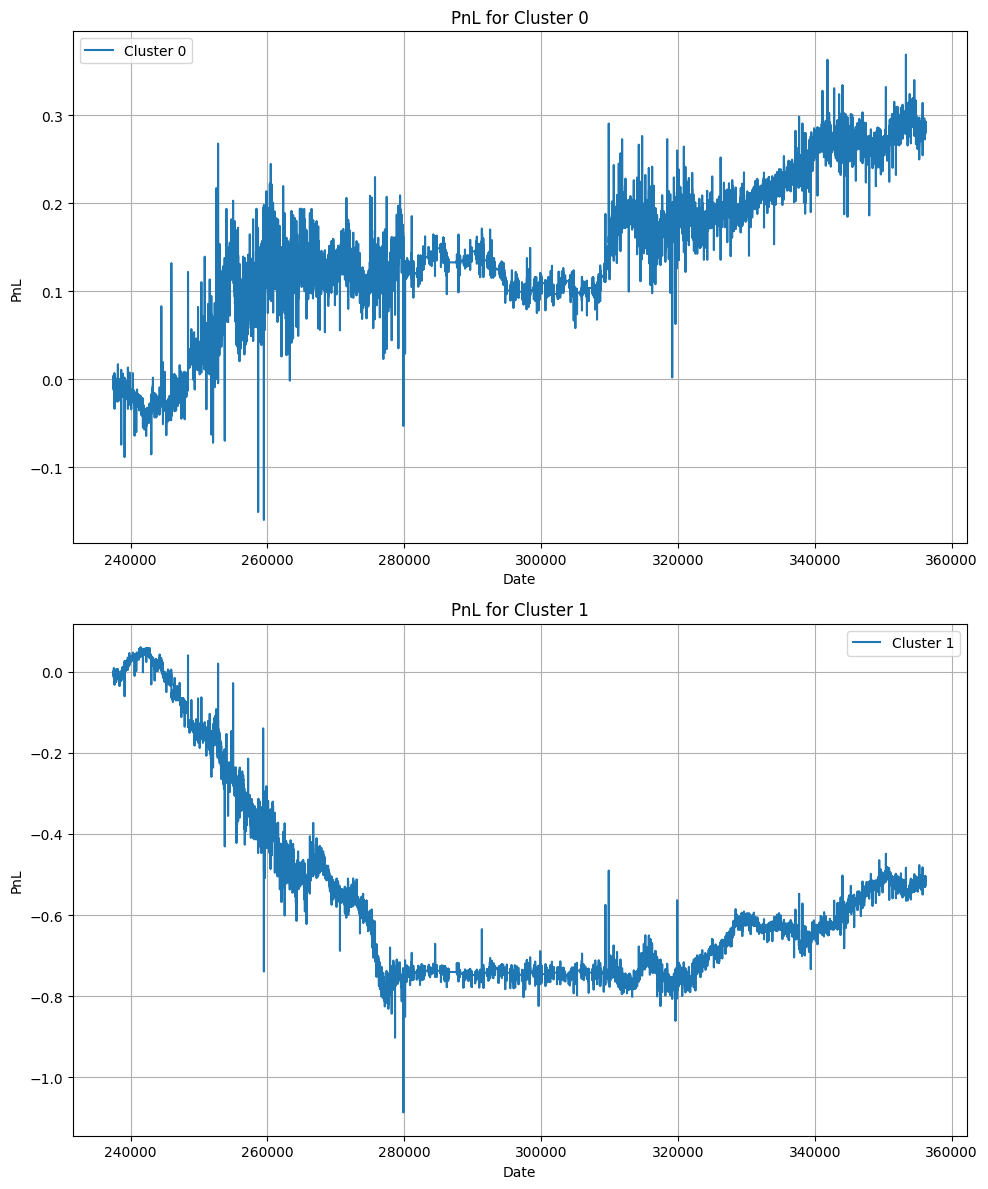

In [64]:
pnl_data = []
sharpe_list = []
result = None
trade_threshold  = 0.0005

# Create a single figure and set of subplots
fig, axes = plt.subplots(len(selected_columns_cluster), figsize=(10, 12))

for idx, data_item in enumerate(selected_columns_cluster):
#     _, hold_out_cols = split_data(data_item)
    train_cols, _ = split_data(data_item)
    optuna_data = scale_data(train_cols)
    _, hold_out_cols = split_data(data_item)
    optuna_data = optuna_data.replace([np.inf, -np.inf], np.nan)
    optuna_data = optuna_data.fillna(0).astype(np.float64)
    hold_out_cols = hold_out_cols.replace([np.inf, -np.inf], np.nan)
    hold_out_cols = hold_out_cols.fillna(0).astype(np.float64)

    xbg_reg = GradientBoostingRegressor()
    # Create and train model
#     xbg_reg.load_model(f"best_in_cluster_{idx}.json")
    with open(f"best_in_cluster_{idx}.pkl", 'rb') as f:
        xbg_reg = pickle.load(f)
    # Make predictions
    hold_out_cols.columns = optuna_data.columns
    y_hold_out = xbg_reg.predict(hold_out_cols)
    pos, pnl, daily, sharpe = sharpe_for_vn30f(y_hold_out, hold_out['Return'], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    print(f"Pnl ratio for cluster {idx}: {pnl}")
    # Append PnL data to the list
    pnl_data.append(pnl)
    result = return_result_df(hold_out, y_hold_out, data, train_data, pos, pnl)
    sharpe_list.append(sharpe)
    
    # Plot PnL for each cluster
    if len(selected_columns_cluster) == 1:
        ax = axes
    else:
        ax = axes[idx]

    ax.plot(pnl, label=f'Cluster {idx}')
    ax.set_title(f'PnL for Cluster {idx}')
    ax.set_xlabel('Date')
    ax.set_ylabel('PnL')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [65]:
#Top 10 feature into list
feature=[]
for i in top_10_features_per_cluster:
    listToStr = ' '.join([str(elem) for elem in i])
    feature.append(listToStr)
print(feature)

['14 0 6 4 11 2 9 7 12 1', '1 6 0 9 4 8 5 10 13 2']


In [66]:
name=[]
for i in range(len(selected_columns_cluster)):
  name.append( 'Cluster '+ str(i))

In [67]:
dict = {'Top 10 Feature' : feature, 'Best params': best_params_list, 'Best sharpe':sharpe_list}
df_result = pd.DataFrame(dict, index=name)
df_result

,Top 10 Feature,Best params,Best sharpe
Cluster 0,14 0 6 4 11 2 9 7 12 1,"{'n_estimators': 177, 'learning_rate': 0.01861...",0.809685
Cluster 1,1 6 0 9 4 8 5 10 13 2,"{'n_estimators': 223, 'learning_rate': 0.03728...",-1.270859


In [68]:
#DataFrame of Pnl hold out
df_pnl = pd.DataFrame()
for i in range(len(selected_columns_cluster)):
  df_pnl[name[i]]=pnl_data[i]
df_pnl

,Cluster 0,Cluster 1
237494,NaN,NaN
237495,NaN,NaN
237496,NaN,NaN
237497,NaN,NaN
237498,NaN,NaN
...,...,...
356235,0.285851,-0.512207
356236,0.285851,-0.512207
356237,0.285851,-0.512207
356238,0.285851,-0.512207


In [69]:
df_result.to_csv('gbr_result.csv')

In [70]:
df_result

,Top 10 Feature,Best params,Best sharpe
Cluster 0,14 0 6 4 11 2 9 7 12 1,"{'n_estimators': 177, 'learning_rate': 0.01861...",0.809685
Cluster 1,1 6 0 9 4 8 5 10 13 2,"{'n_estimators': 223, 'learning_rate': 0.03728...",-1.270859
